In [52]:
library(data.table)
library(forecast)
library(dplyr)
library(huxtable)
library(magrittr)
library(kableExtra)
library(tseries)
library(gridExtra)
library(ggplot2)
options(repr.plot.width=18, repr.plot.height=12)

In [50]:
setwd('<PATH HERE>')
data = fread('Medium Test Set.csv')

In [155]:
tail(data,10)

DATE,Retail Total Sales,US Total Sales,Amazon_Revenue,Fedex_Revenue
<chr>,<int>,<dbl>,<dbl>,<dbl>
1/1/17,99805,2.60e+12,43740,14.93
4/1/17,107094,2.74e+12,35710,15.00
7/1/17,108905,3.13e+12,37950,15.73
10/1/17,145230,2.86e+12,43740,15.30
1/1/18,115602,2.88e+12,60450,16.31
4/1/18,122934,3.03e+12,51040,16.53
7/1/18,124214,3.44e+12,52890,17.31
10/1/18,160894,3.01e+12,56580,17.05
1/1/19,129015,2.99e+12,72380,17.82


In [154]:
head(data,10)

DATE,Retail Total Sales,US Total Sales,Amazon_Revenue,Fedex_Revenue
<chr>,<int>,<dbl>,<dbl>,<dbl>
10/1/99,5241,2.53e+11,355.80,4.320
1/1/00,5553,2.38e+11,676.00,4.570
4/1/00,6059,2.47e+11,573.89,4.518
7/1/00,6892,3.00e+11,577.88,4.849
10/1/00,9104,2.80e+11,637.86,4.779
1/1/01,7923,2.62e+11,972.36,4.895
4/1/01,7816,2.70e+11,700.36,4.839
7/1/01,7737,3.27e+11,667.63,5.117
10/1/01,10784,3.09e+11,639.28,5.037


In [13]:
#Transforming dates to quarterly format
continuity<- function(x,num)
  {
  cont = vector(mode = 'character',length = num)
  ctr = 1
  getting_it<-strsplit(x,"(?=[Q])", perl = TRUE)
  yr<- getting_it[[1]][1]
  qrt<- getting_it[[1]][3]
  while (ctr<=num){
    if (as.numeric(qrt) > 3) {
      qrt<-1
      yr<-as.character(as.numeric(yr)+1)
      cont[ctr] = paste(yr,'Q',qrt,sep = "")
      ctr = ctr+1
    }else{
      qrt<-as.character(as.numeric(qrt)+1)
      yr<-yr
      cont[ctr] = paste(yr,'Q',qrt,sep = "")
      ctr = ctr+1
    }
  }
 return(cont) 
}

data$DATE<-continuity('1999Q3',NROW(data))

In [45]:
#Adding Percentage growth by period
perc_growth<-function(x){
  vec = vector(mode='numeric',length =0L)
  ctr=1
  for (i in 1:NROW(x)){
    if ((i+1) <= NROW(x)){
    vec[ctr+1] = (x[i+1]-x[i])/x[i]*100
    ctr <- ctr+1
  }
  }
  return(vec)
  }

data$Perc_Growth_Total<-perc_growth(data$`Retail Total Sales`)
data$Perc_Growth_USA<-perc_growth(data$`US Total Sales`)
data$Perc_Growth_AMZN<-perc_growth(data$`Amazon_Revenue`)
data$Perc_Growth_FEDEX<-perc_growth(data$`Fedex_Revenue`)

In [47]:
#Transforming data to TS format
data_Perc_TS = ts(data = data[,'Perc_Growth_Total'],start = c(1999,4),frequency =4)
data_Perc_US = ts(data = data[,'Perc_Growth_USA'],start = c(1999,4),frequency =4)
data_Perc_AMZN = ts(data = data[,'Perc_Growth_AMZN'],start = c(1999,4),frequency =4)
data_Perc_FEDEX = ts(data = data[,'Perc_Growth_FEDEX'],start = c(1999,4),frequency =4)

Warning message:
“Removed 2 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_path).”


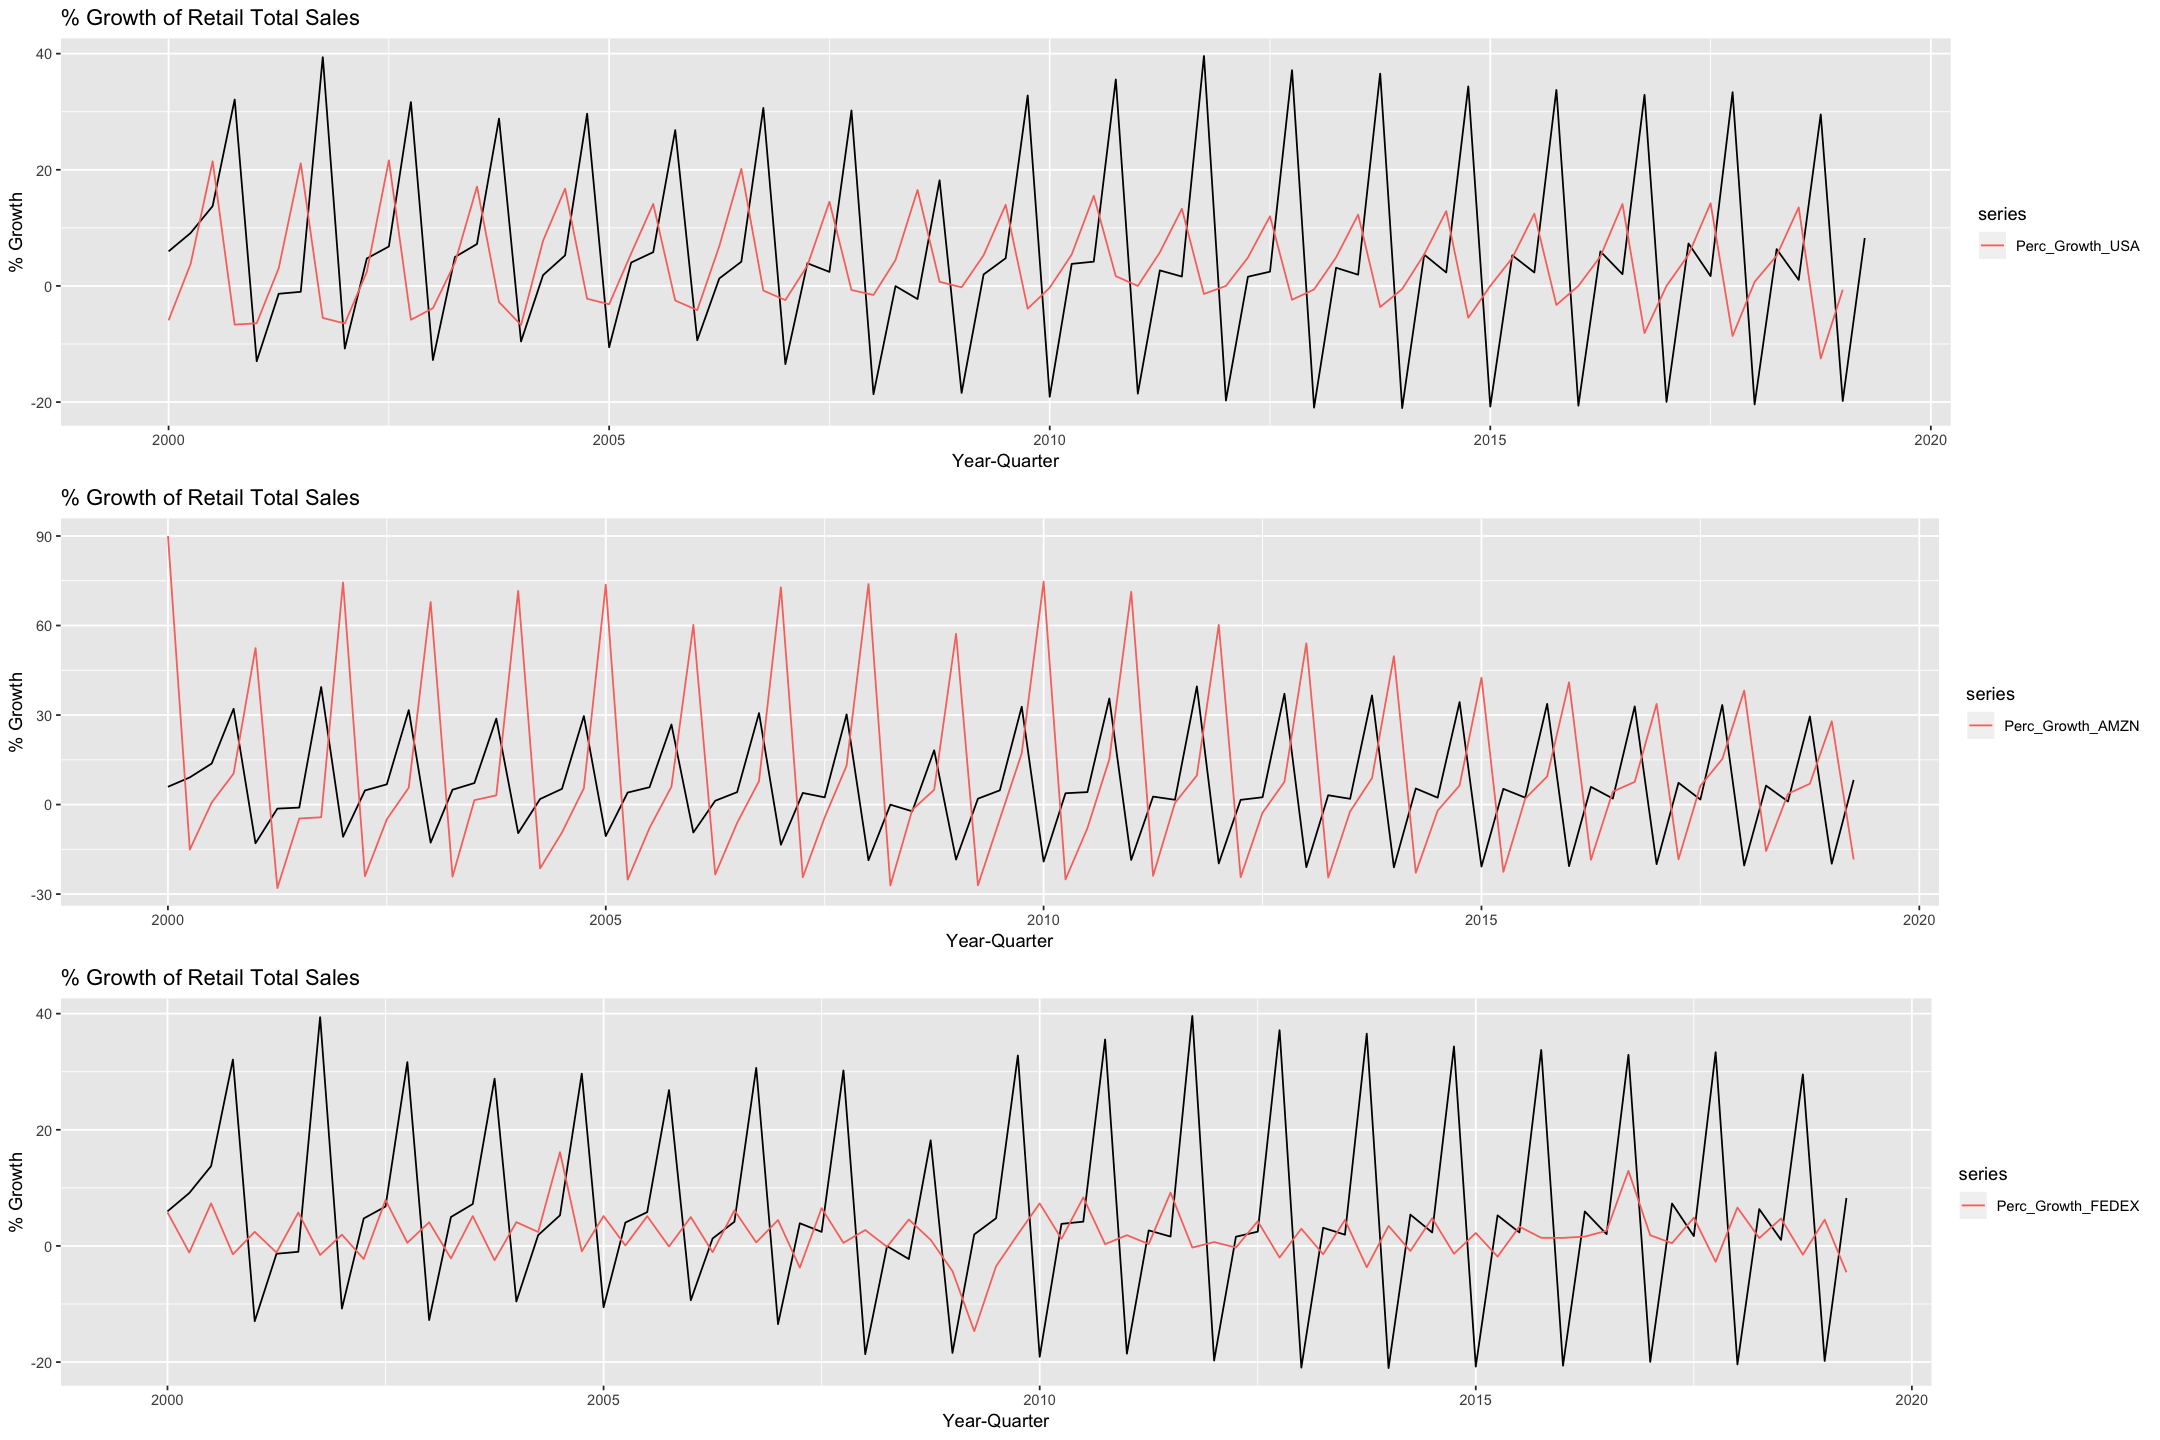

In [53]:
plot_arrange<- function(main,layer){
  plot_list = list()
  for (i in 1:length(layer)){
    name<-colnames(layer[[i]])
    p = autoplot(main,main= '% Growth of Retail Total Sales',series = 'Total E-Commerce Sales',ylab = '% Growth',xlab='Year-Quarter',col = c('black'))+
  autolayer(layer[[i]],series = name,colour = T)
  plot_list<-append(plot_list,list(p))
  }
  n <- length(plot_list)
  nCol <- floor(sqrt(n))
  do.call("grid.arrange", c(plot_list, ncol=nCol))
}

plot_arrange(data_Perc_TS,list(data_Perc_US,data_Perc_AMZN,data_Perc_FEDEX))

In [57]:
dataTS = ts(data = data$`Retail Total Sales`,start = c(1999,4),frequency=4)
dataUS = ts(data = data$`US Total Sales`,start = c(1999,4),end = c(2019,1),frequency=4)
dataAMZN = ts(data = data$Amazon_Revenue,start = c(1999,4),frequency=4)
dataFEDEX = ts(data = data$Fedex_Revenue,start = c(1999,4),frequency=4)

decomp <- function(x,transform=TRUE)
{
  require(forecast)
   
  #Transform series
  if(transform & min(x,na.rm=TRUE) >= 0)
  {
    lambda <- BoxCox.lambda(na.contiguous(x))
    x <- BoxCox(x,lambda)
  }
  else
  {
    lambda <- NULL
    transform <- FALSE
  }
  
  # Seasonal data
  if(frequency(x)>1)
  {
    x.stl <- stl(x,s.window="periodic")
    trend <- x.stl$time.series[,2]
    season <- x.stl$time.series[,1]
    remainder <- x - trend - season
  }
  else #Nonseasonal data
  {
    require(mgcv)
    tt <- 1:length(x)
    trend <- rep(NA,length(x))
    trend[!is.na(x)] <- fitted(gam(x ~ s(tt)))
    season <- NULL
    remainder <- x - trend
  }
  return(list(x=x,trend=trend,season=season,remainder=remainder,transform = transform,lambda=lambda))
}




In [58]:
measures <- function(x)
{
  require(forecast)
  
  freq <- findfrequency(x)
  fx <- c(frequency=(exp((freq-1)/50)-1)/(1+exp((freq-1)/50)))
  x<- ts(x,frequency = 4)
  freq <- 4
  
  # Decomposition
  decomp.x <- decomp(x)
  
  # Adjust data
  if(freq > 1)
    fits <- decomp.x$trend + decomp.x$season
  else # Nonseasonal data
    fits <- decomp.x$trend
  adj.x <- decomp.x$x - fits + mean(decomp.x$trend, na.rm=TRUE)
  
  # Backtransformation of adjusted data
  if(decomp.x$transform)
    tadj.x <- InvBoxCox(adj.x,decomp.x$lambda)
  else
    tadj.x <- adj.x
  
  # Trend and seasonal measures
  # avoids the divide by zero problem by testing if the variances are close to zero first
  v.adj <- var(adj.x, na.rm=TRUE)
  if(freq > 1)
  {
    detrend <- decomp.x$x - decomp.x$trend
    deseason <- decomp.x$x - decomp.x$season
    trend <- ifelse(var(deseason,na.rm=TRUE) < 1e-10, 0, 
                    max(0,min(1,1-v.adj/var(deseason,na.rm=TRUE))))
    season <- ifelse(var(detrend,na.rm=TRUE) < 1e-10, 0,
                     max(0,min(1,1-v.adj/var(detrend,na.rm=TRUE))))
  }
  else #Nonseasonal data
  {
    trend <- ifelse(var(decomp.x$x,na.rm=TRUE) < 1e-10, 0,
                    max(0,min(1,1-v.adj/var(decomp.x$x,na.rm=TRUE))))
    season <- 0
  }
  
  m <- c(trend,season)
  
  # Measures on original data
  names(m) <- c("Trend","Seasonal")
  
  return(m)
}


In [59]:
x<-data.frame(`US Only` = round(measures(dataUS),2),
           `Total ECom Sales` = round(measures(dataTS),2),
           `AMZN_Revenue` = round(measures(dataAMZN),2),
           `FEDEX_Revenue` = round(measures(dataFEDEX),2))
x

,US.Only,Total.ECom.Sales,AMZN_Revenue,FEDEX_Revenue
,<dbl>,<dbl>,<dbl>,<dbl>
Trend,1.00,1.00,1.00,1.00
Seasonal,0.92,0.96,0.97,0.45


In [60]:
stl_TS <- tsclean(dataTS)
stl_1 <- stl(stl_TS,s.window = 'periodic')
head(stl_1$time.series,20)

,seasonal,trend,remainder
1999 Q4,6205.211,2583.788,-3547.9990
2000 Q1,-2214.414,4388.332,3379.0815
2000 Q2,-1487.941,5986.380,1560.5604
2000 Q3,-2502.862,7167.048,2227.8142
2000 Q4,6205.211,7526.099,-4627.3098
2001 Q1,-2214.414,8003.799,2133.6147
2001 Q2,-1487.941,8643.945,659.9955
2001 Q3,-2502.862,8697.881,1541.9810
2001 Q4,6205.211,9062.367,-4483.5775
2002 Q1,-2214.414,9888.498,1946.9154


In [136]:
#Dependent Variable
trainUS = window(dataUS,start = c(2000,1),end = c(2018,1)) 
testUS = window(dataUS,start = c(2018,2)) 

testUS<-na.omit(testUS) #eliminating NAs as this do nothing for the forecast

#Regressor US Total Sales
trainREG_TS = window(dataTS,start = c(2000,1),end = c(2018,1)) 
testREG_TS = window(dataTS,start = c(2018,2)) 

testREG_TS<-na.omit(testREG_TS) #eliminating NAs
trainREG_TS<-as.matrix(trainREG_TS)
testREG_TS<-as.matrix(testREG_TS)

#Regressor AMZN Revenue
trainREG_AMZN = window(dataAMZN,start = c(2000,1),end = c(2018,1)) 
testREG_AMZN = window(dataAMZN,start = c(2018,2)) 

testREG_AMZN<-na.omit(testREG_AMZN) #eliminating NAs
trainREG_AMZN<-as.matrix(trainREG_AMZN)
testREG_AMZN<-as.matrix(testREG_AMZN)

#Regressor FEDEX Revenue
trainREG_FEDEX = window(dataFEDEX,start = c(2000,1),end = c(2018,1)) 
transf_TSFEDEX<- BoxCox(trainREG_FEDEX,lambda = BoxCox.lambda(trainREG_FEDEX))
testREG_FEDEX = window(dataFEDEX,start = c(2018,2)) 
test_transf_FEDEX<-BoxCox(testREG_FEDEX,lambda = BoxCox.lambda(testREG_FEDEX))

testREG_FEDEX<-na.omit(testREG_FEDEX) #eliminating NAs
trainREG_FEDEX<-as.matrix(trainREG_FEDEX)
testREG_FEDEX<-as.matrix(testREG_FEDEX)

In [137]:
#Modeling With US Data
fit_basic1<- auto.arima(trainUS,xreg=trainREG_TS)
forecast_1<-forecast(fit_basic1,xreg = testREG_TS);forecast_1
acc_US_less<-accuracy(f = forecast_1,x = testUS);acc_US_less

summary(fit_basic1)

        Point Forecast        Lo 80        Hi 80        Lo 95        Hi 95
2018 Q2   3.038528e+12 2.956849e+12 3.120207e+12 2.913611e+12 3.163446e+12
2018 Q3   3.420235e+12 3.338556e+12 3.501915e+12 3.295318e+12 3.545153e+12
2018 Q4   3.155779e+12 3.074100e+12 3.237459e+12 3.030862e+12 3.280697e+12
2019 Q1   3.140625e+12 3.058946e+12 3.222304e+12 3.015707e+12 3.265542e+12
2019 Q2   3.351065e+12 3.235553e+12 3.466577e+12 3.174405e+12 3.527725e+12

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,6930989,61059250163,50427116886,-3.654648,7.458758,0.3299641,0.7169445,NA
Test set,-71291963004,105359968596,81174296036,-2.396924,2.684201,0.5311547,0.2011321,0.3574942


Series: trainUS 
Regression with ARIMA(0,0,0)(0,1,0)[4] errors 

Coefficients:


Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”


            drift      xreg
      12787481421  15617311
s.e.          NaN       NaN

sigma^2 estimated as 4.062e+21:  log likelihood=-1813.47
AIC=3632.95   AICc=3633.32   BIC=3639.65

Training set error measures:
                  ME        RMSE         MAE       MPE     MAPE      MASE
Training set 6930989 61059250163 50427116886 -3.654648 7.458758 0.3299641
                  ACF1
Training set 0.7169445


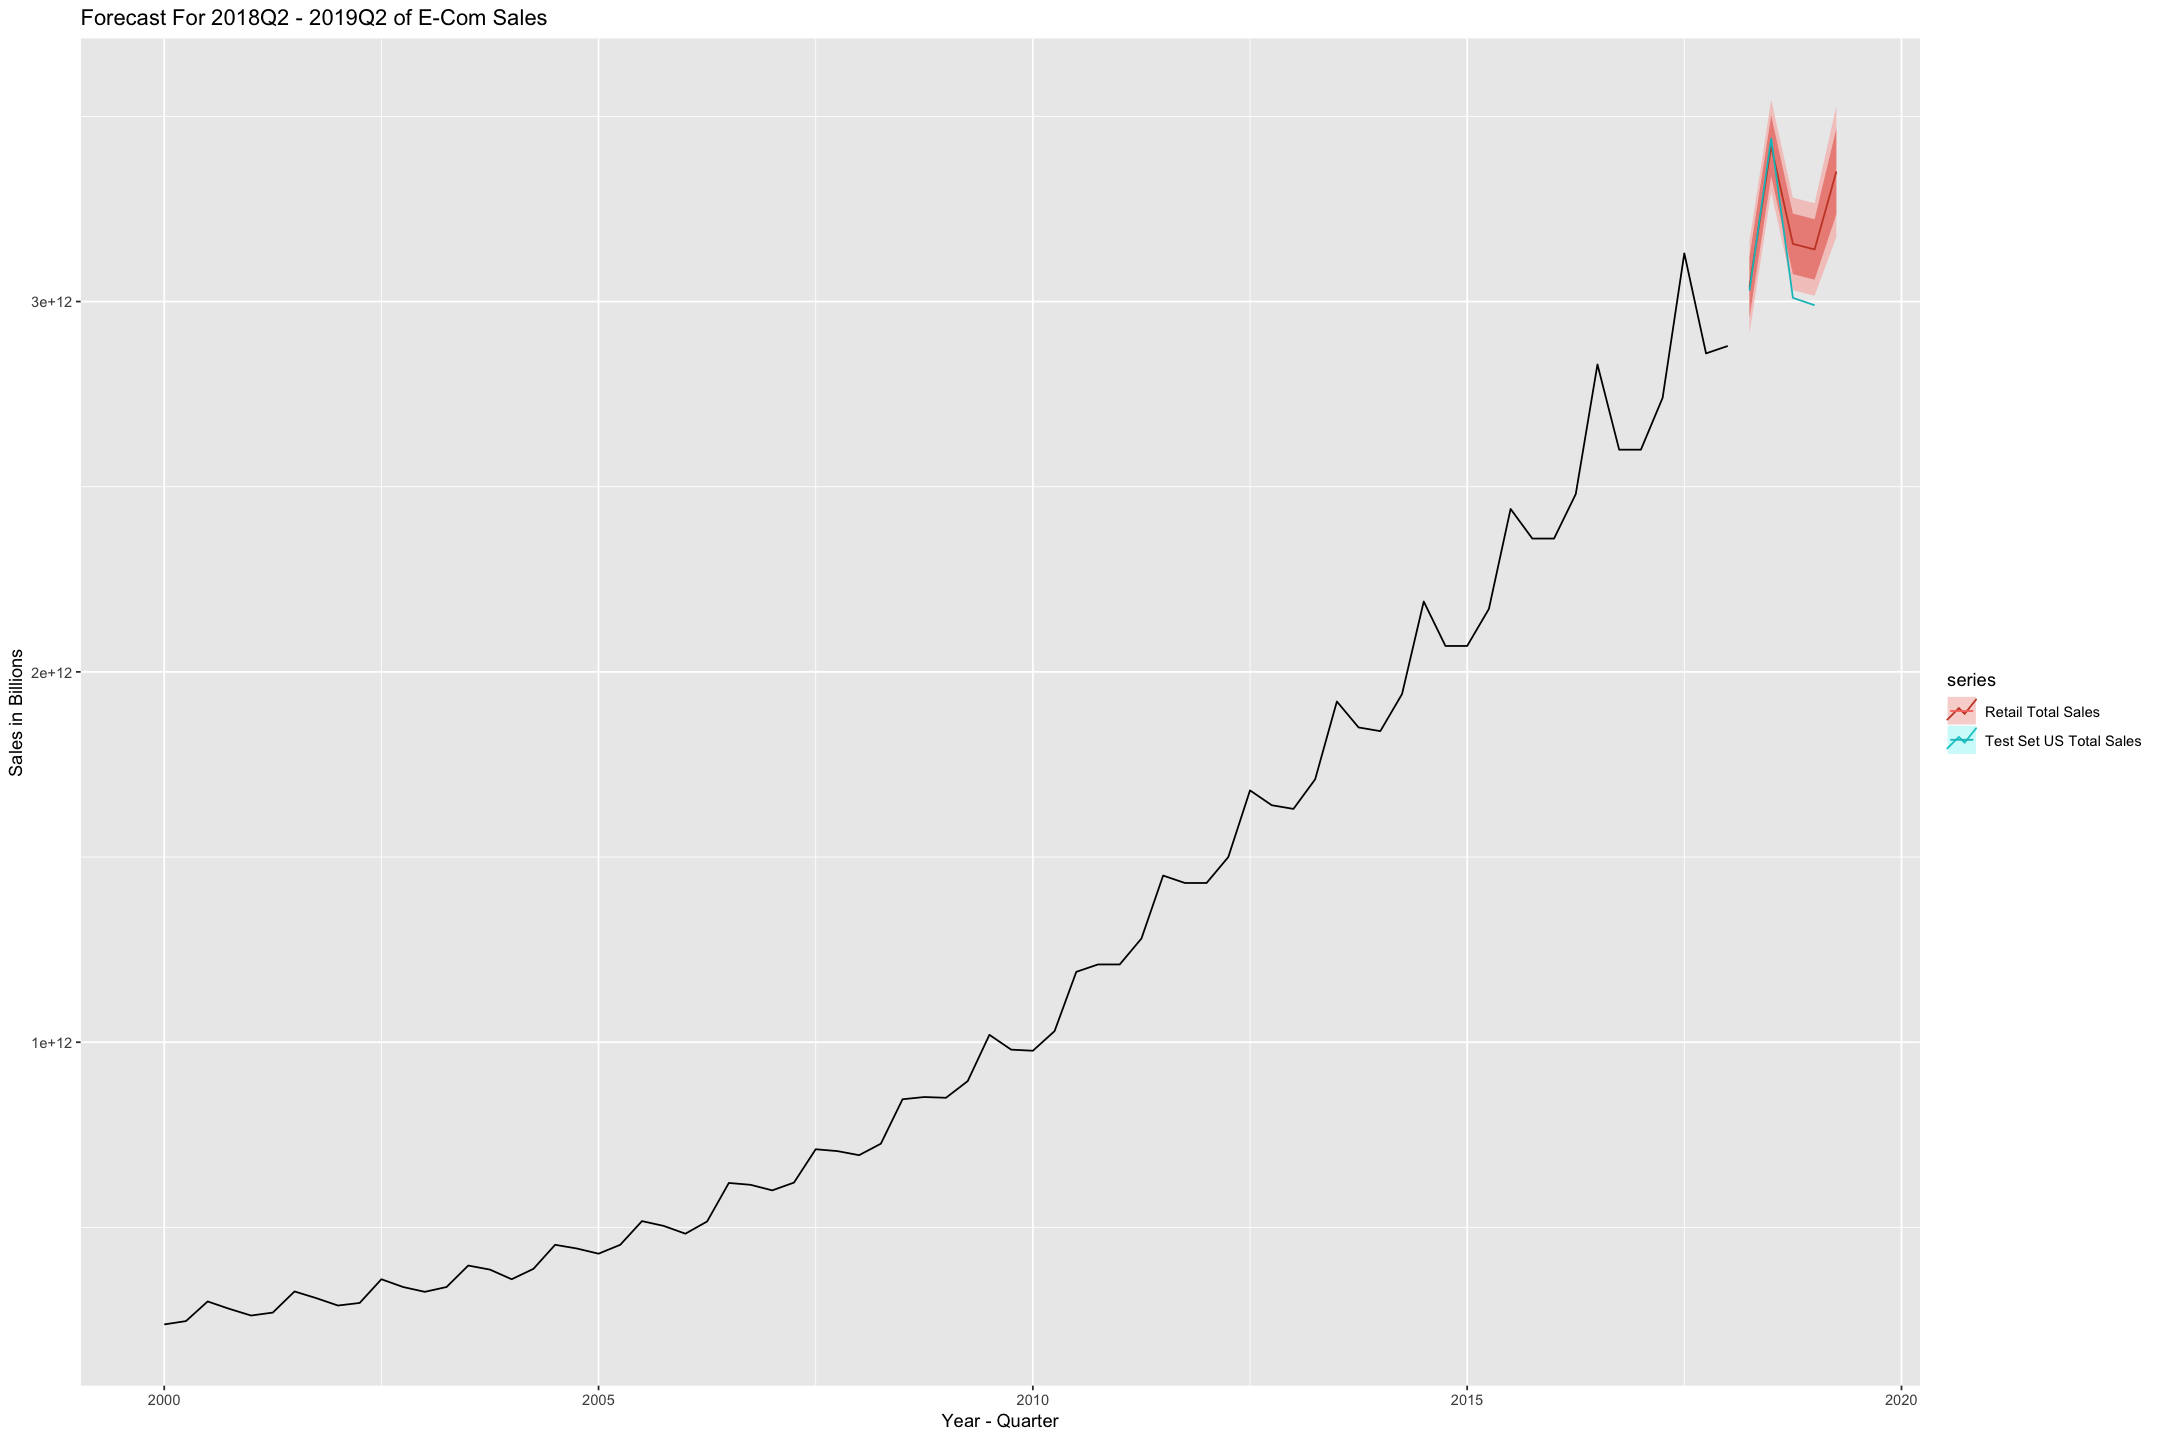

In [220]:
autoplot(trainUS,main = 'Forecast For 2018Q2 - 2019Q2 of E-Com Sales',xlab = 'Year - Quarter',ylab = 'Sales in Billions')+
  autolayer(forecast_1, "Retail Total Sales")+
  autolayer(testUS,series = 'Test Set US Total Sales')

In [139]:
#Modeling with Amazon Data
fit_basic2<- auto.arima(trainUS,xreg = trainREG_AMZN)
forecast_2<-forecast(fit_basic2,xreg = testREG_AMZN);forecast_2
acc_AMZN_less <-accuracy(f = forecast_2,x = testUS);acc_AMZN_less

summary(fit_basic2)

Warning message in auto.arima(trainUS, xreg = trainREG_AMZN):
“Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.”


        Point Forecast        Lo 80        Hi 80        Lo 95        Hi 95
2018 Q2   3.044705e+12 3.000218e+12 3.089191e+12 2.976669e+12 3.112740e+12
2018 Q3   3.554910e+12 3.488658e+12 3.621163e+12 3.453585e+12 3.656235e+12
2018 Q4   3.313116e+12 3.201803e+12 3.424430e+12 3.142877e+12 3.483356e+12
2019 Q1   3.401430e+12 3.253280e+12 3.549580e+12 3.174854e+12 3.628006e+12
2019 Q2   3.677807e+12 3.463094e+12 3.892521e+12 3.349431e+12 4.006184e+12

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1873728089,32502589491,20559721125,0.1367818,1.562875,0.1345302,-0.08563891,NA
Test set,-211040174780,261999273152,211040174780,-6.9140524,6.914052,1.3809172,0.29529946,0.9059176


Series: trainUS 
Regression with ARIMA(1,2,0)(1,1,0)[4] errors 

Coefficients:
          ar1     sar1       xreg
      -0.8964  -0.5366  -23788094
s.e.   0.0732   0.1416    3586416

sigma^2 estimated as 1.205e+21:  log likelihood=-1724.74
AIC=3457.48   AICc=3458.12   BIC=3466.3

Training set error measures:
                     ME        RMSE         MAE       MPE     MAPE      MASE
Training set 1873728089 32502589491 20559721125 0.1367818 1.562875 0.1345302
                    ACF1
Training set -0.08563891


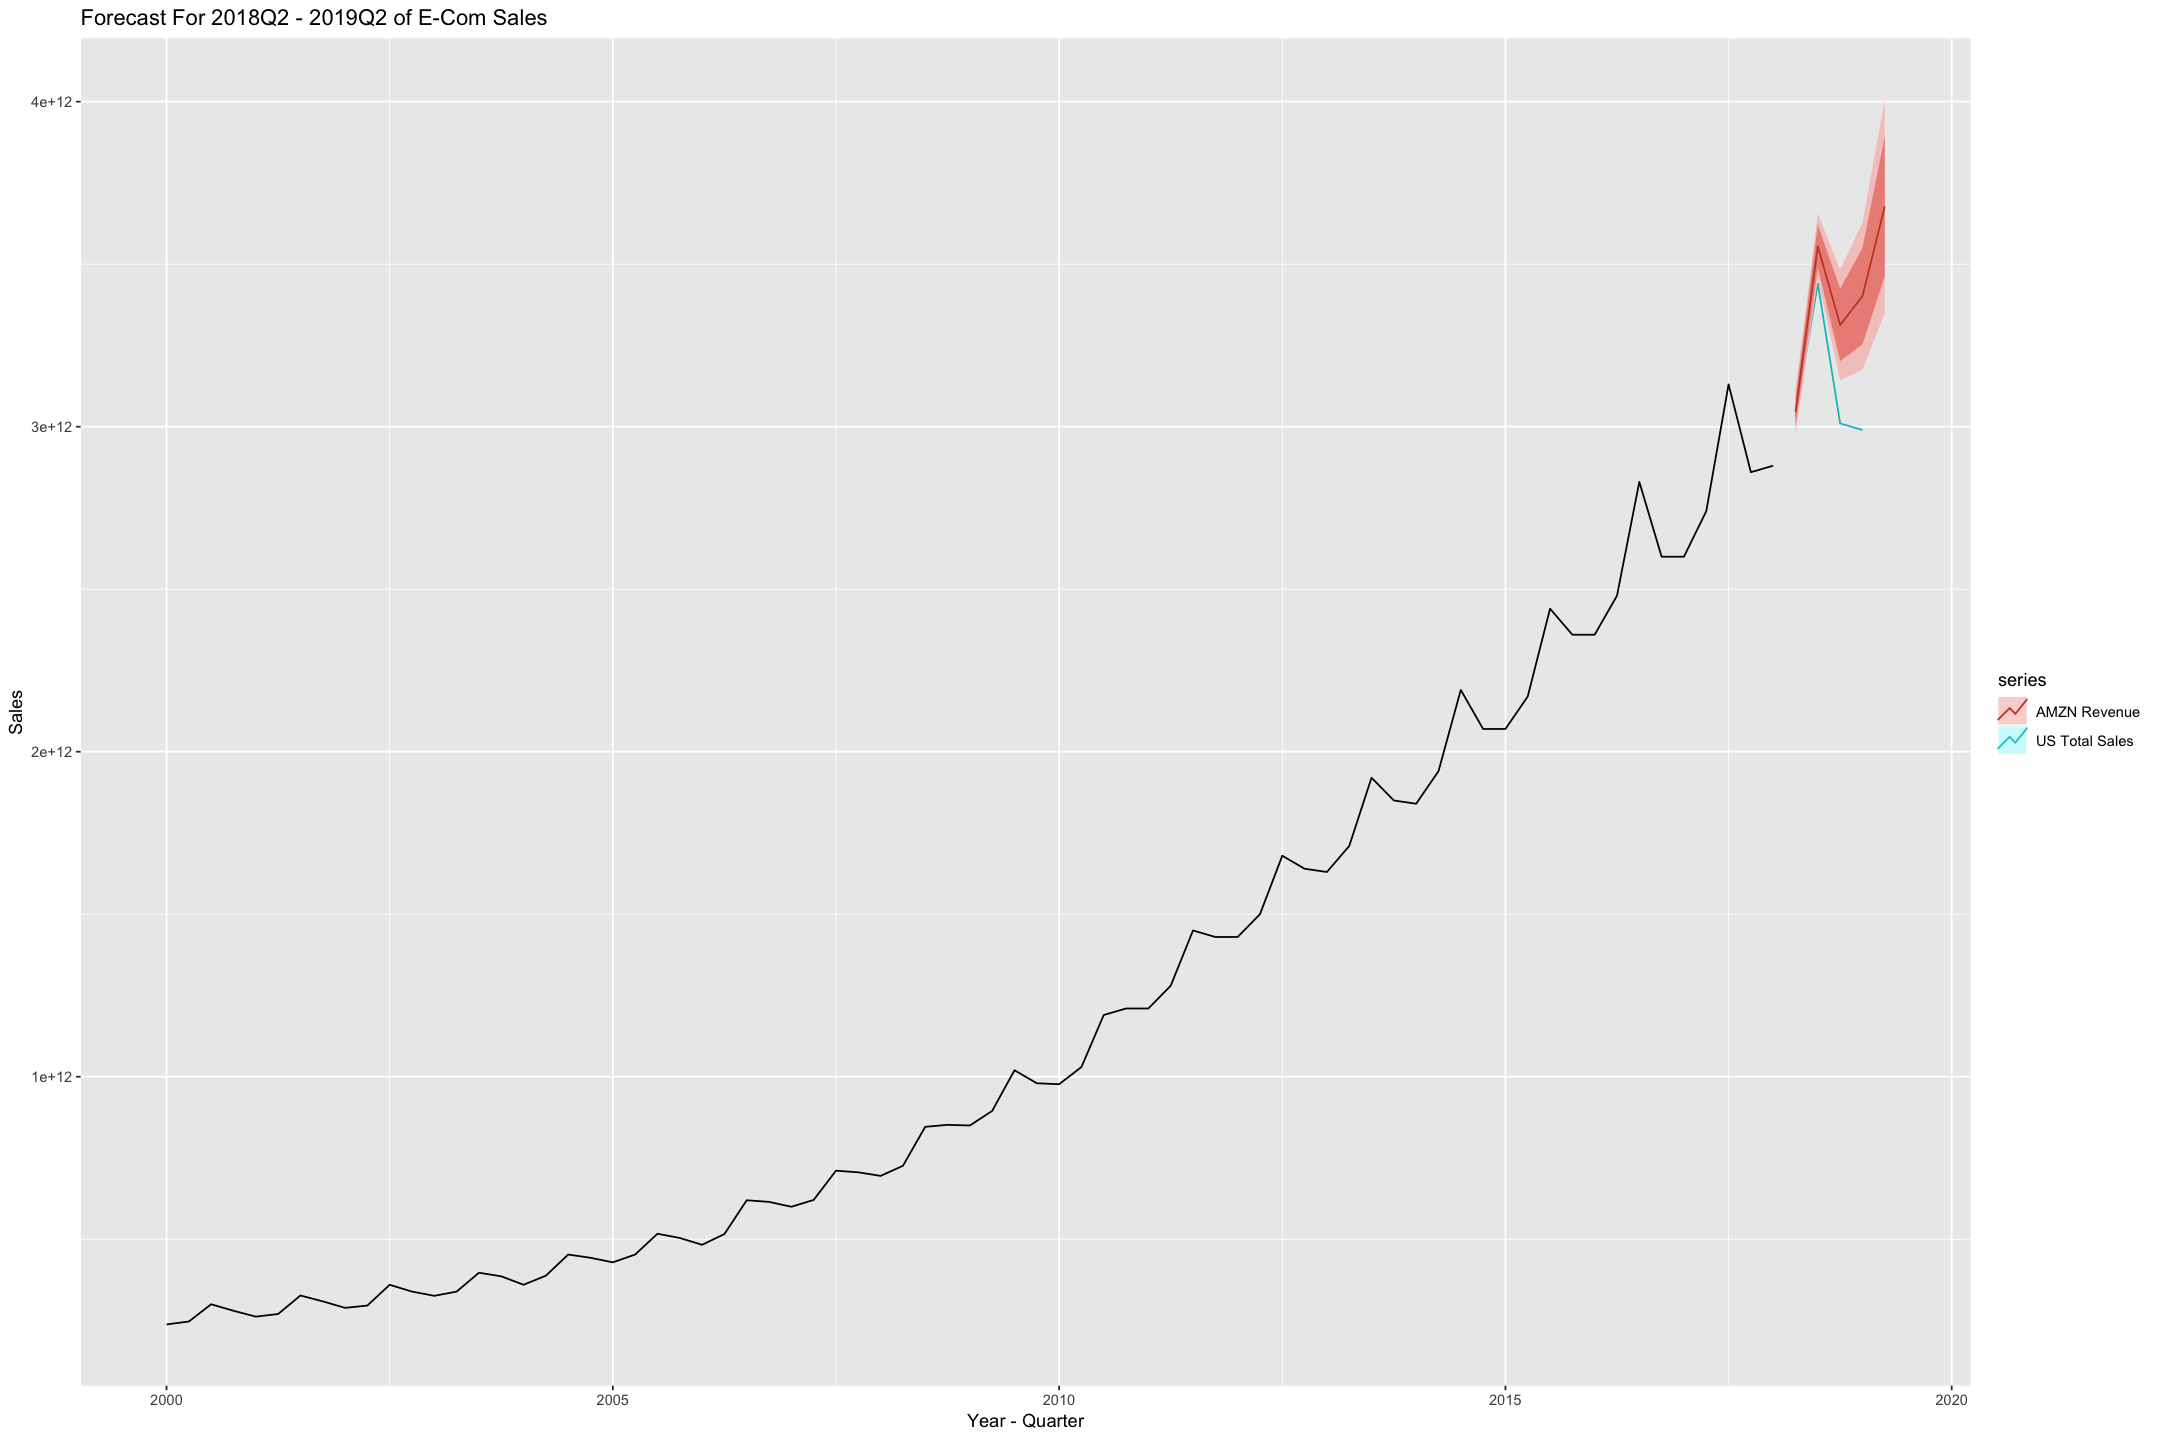

In [203]:
autoplot(trainUS,main = 'Forecast For 2018Q2 - 2019Q2 of E-Com Sales',xlab = 'Year - Quarter',ylab = 'Sales')+
  autolayer(testUS,series = 'US Total Sales')+
  autolayer(forecast_2,series = 'AMZN Revenue')
  

In [141]:
fit_basic3<- auto.arima(trainUS,xreg = trainREG_FEDEX)
forecast_3<-forecast(fit_basic3,xreg = testREG_FEDEX);forecast_3
acc_FEDEX_less <-accuracy(f = forecast_3,x = testUS);acc_FEDEX_less

summary(fit_basic3)

        Point Forecast        Lo 80        Hi 80        Lo 95        Hi 95
2018 Q2   2.919726e+12 2.789599e+12 3.049853e+12 2.720714e+12 3.118738e+12
2018 Q3   2.989264e+12 2.805236e+12 3.173291e+12 2.707818e+12 3.270709e+12
2018 Q4   3.003437e+12 2.778050e+12 3.228823e+12 2.658737e+12 3.348136e+12
2019 Q1   3.072442e+12 2.812188e+12 3.332696e+12 2.674418e+12 3.470466e+12
2019 Q2   3.057335e+12 2.766362e+12 3.348308e+12 2.612331e+12 3.502340e+12

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-4.561735e+05,99430375582,67799333509,-2.050099,6.418876,0.4436372,-0.1534413,NA
Test set,1.212829e+11,235671016221,162503953617,3.550750,4.929380,1.0633260,-0.1105181,0.8206332


Series: trainUS 
Regression with ARIMA(0,1,0) errors 

Coefficients:
            drift         xreg
      28014087650  53235578299
s.e.   1086510880   1300618620

sigma^2 estimated as 1.031e+22:  log likelihood=-1925.9
AIC=3857.79   AICc=3858.15   BIC=3864.62

Training set error measures:
                    ME        RMSE         MAE       MPE     MAPE      MASE
Training set -456173.5 99430375582 67799333509 -2.050099 6.418876 0.4436372
                   ACF1
Training set -0.1534413


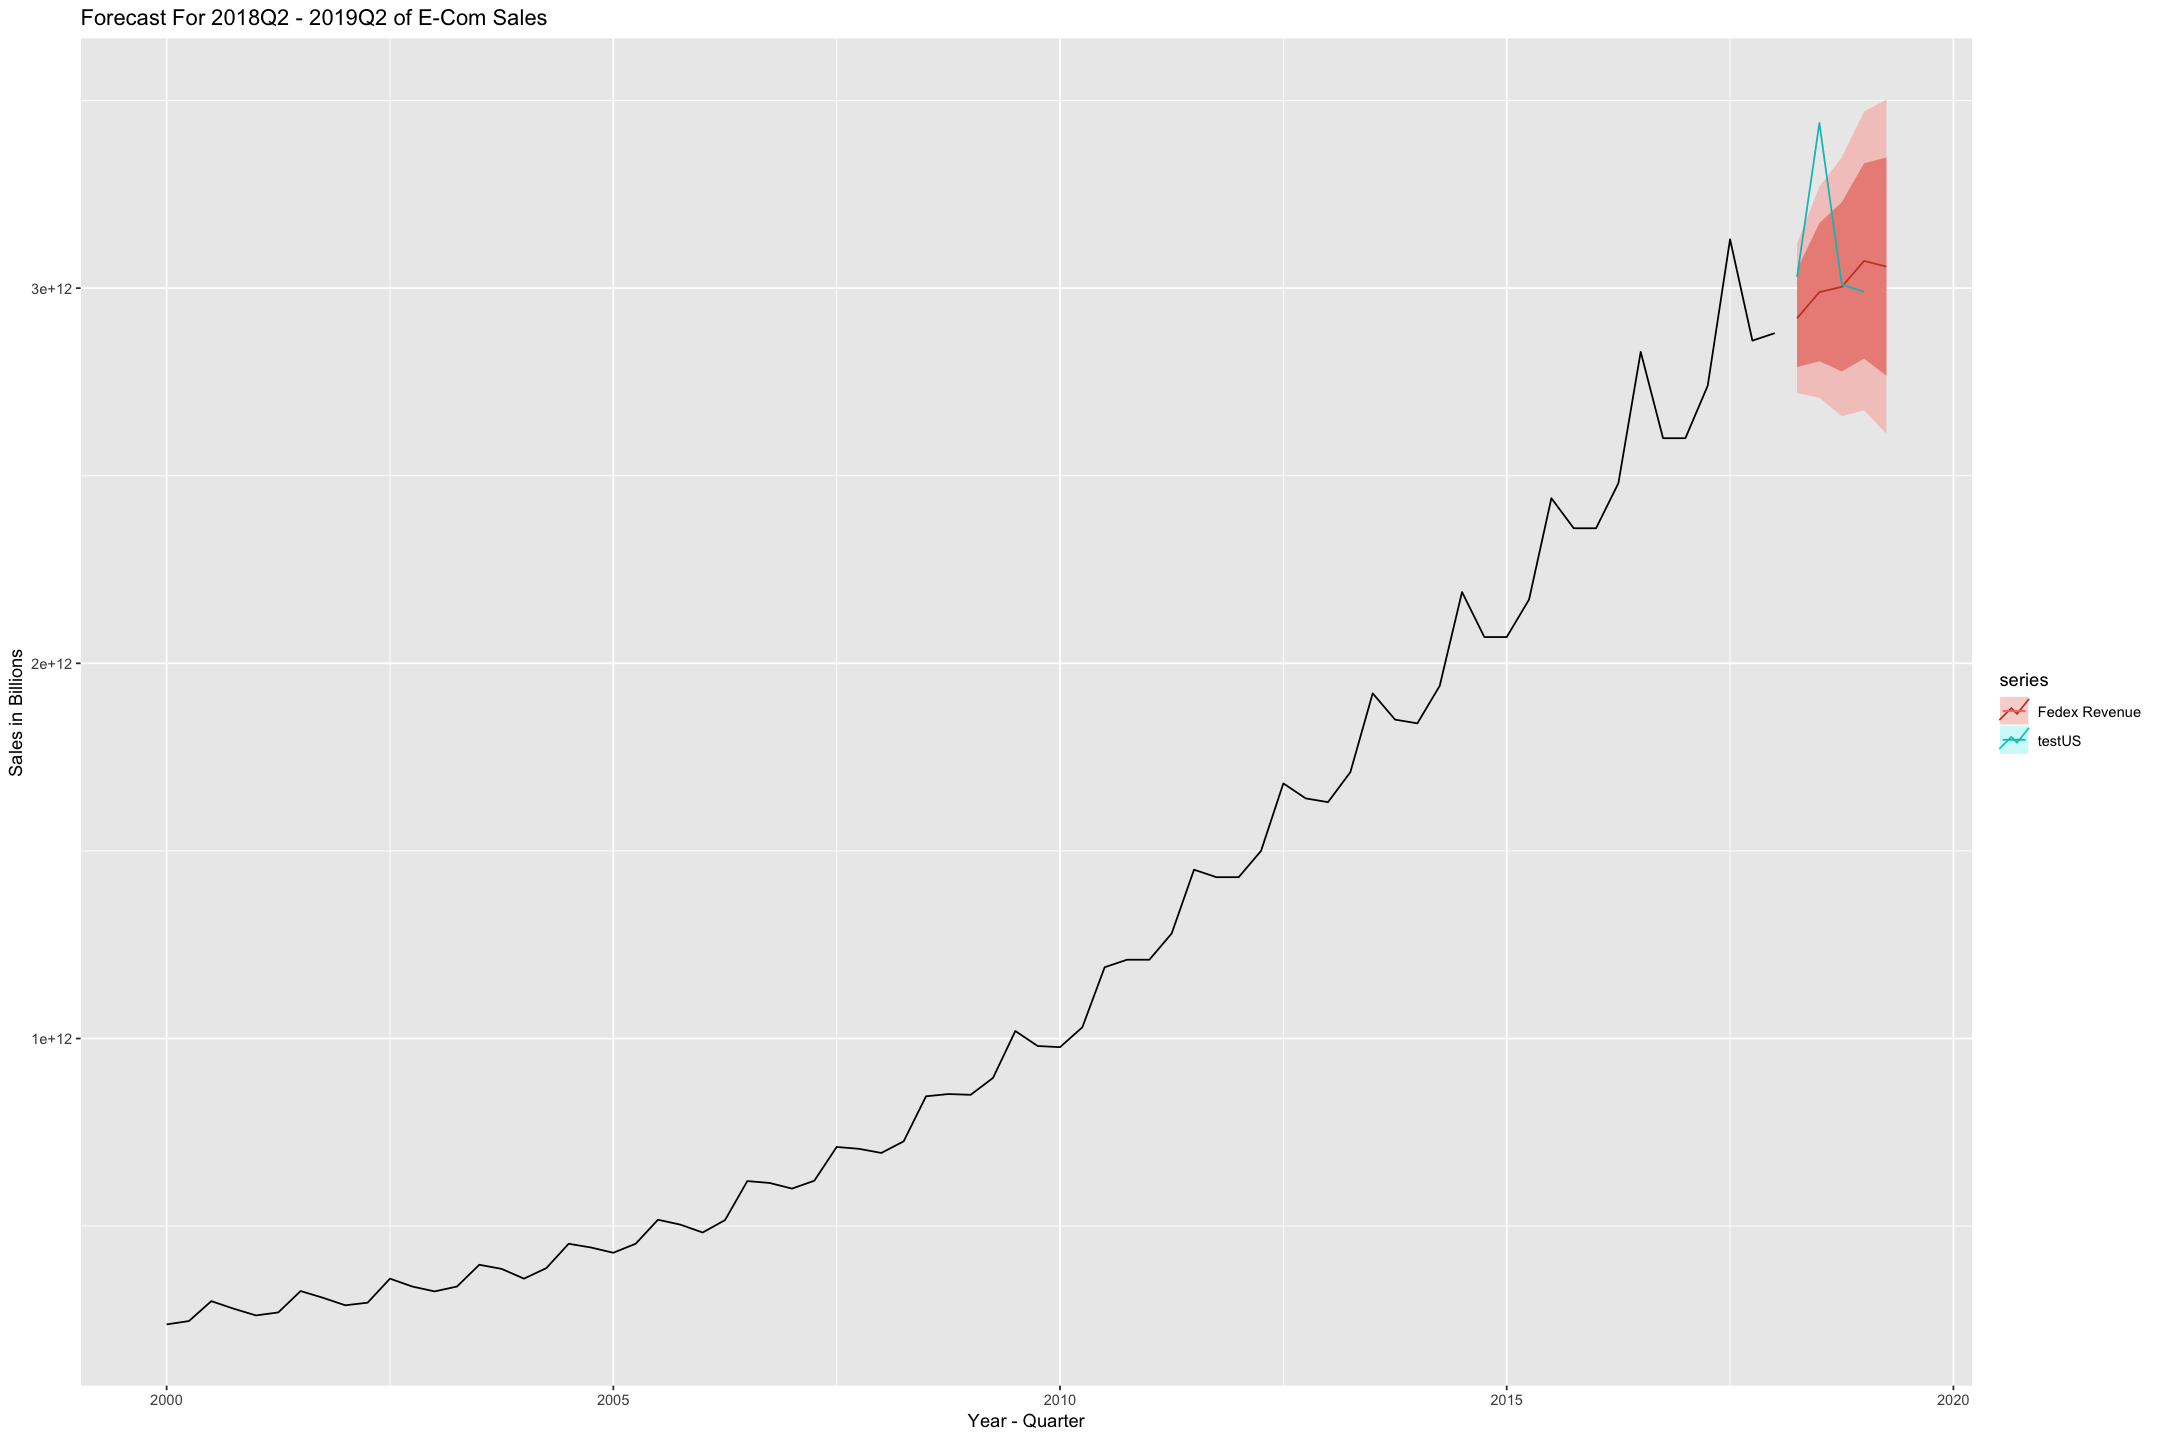

In [200]:
autoplot(trainUS,main = 'Forecast For 2018Q2 - 2019Q2 of E-Com Sales',xlab = 'Year - Quarter',ylab = 'Sales in Billions')+
  autolayer(forecast_3,series = 'Fedex Revenue')+
  autolayer(testUS,series = 'US Total Sales')

## Making the Model Work Harder and Nudging it in the Right Direction

In [205]:
fit_complex1<- auto.arima(trainUS,xreg=trainREG_TS,D=1,approximation = F,allowdrift = T,allowmean = T,lambda = BoxCox.lambda(trainUS))
forecast_complex1<-forecast(fit_complex1,xreg = testREG_TS);forecast_complex1
acc_US_more<-accuracy(f = forecast_complex1,x = testUS);acc_US_more

summary(fit_complex1)

        Point Forecast        Lo 80        Hi 80        Lo 95        Hi 95
2018 Q2   3.021017e+12 2.970547e+12 3.072172e+12 2.944105e+12 3.099532e+12
2018 Q3   3.439413e+12 3.360413e+12 3.519897e+12 3.319186e+12 3.563110e+12
2018 Q4   3.143410e+12 3.053600e+12 3.235327e+12 3.006898e+12 3.284850e+12
2019 Q1   3.177741e+12 3.073314e+12 3.284995e+12 3.019159e+12 3.342937e+12
2019 Q2   3.318296e+12 3.183314e+12 3.457831e+12 3.113664e+12 3.533580e+12

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,122609392,20903516380,13254844645,0.169811,1.177117,0.08673156,-0.06367808,NA
Test set,-77895244613,115245228253,82680094187,-2.599414,2.756175,0.54100773,0.29663697,0.3984433


Series: trainUS 
Regression with ARIMA(0,1,0)(1,1,0)[4] errors 
Box Cox transformation: lambda= 0.1977409 

Coefficients:
         sar1    xreg
      -0.4916  -5e-04
s.e.   0.1003   2e-04

sigma^2 estimated as 14.85:  log likelihood=-187.63
AIC=381.25   AICc=381.63   BIC=387.91

Training set error measures:
                    ME        RMSE         MAE      MPE     MAPE       MASE
Training set 122609392 20903516380 13254844645 0.169811 1.177117 0.08673156
                    ACF1
Training set -0.06367808



	Ljung-Box test

data:  Residuals from Regression with ARIMA(0,1,0)(1,1,0)[4] errors
Q* = 2.1069, df = 6, p-value = 0.9096

Model df: 2.   Total lags used: 8



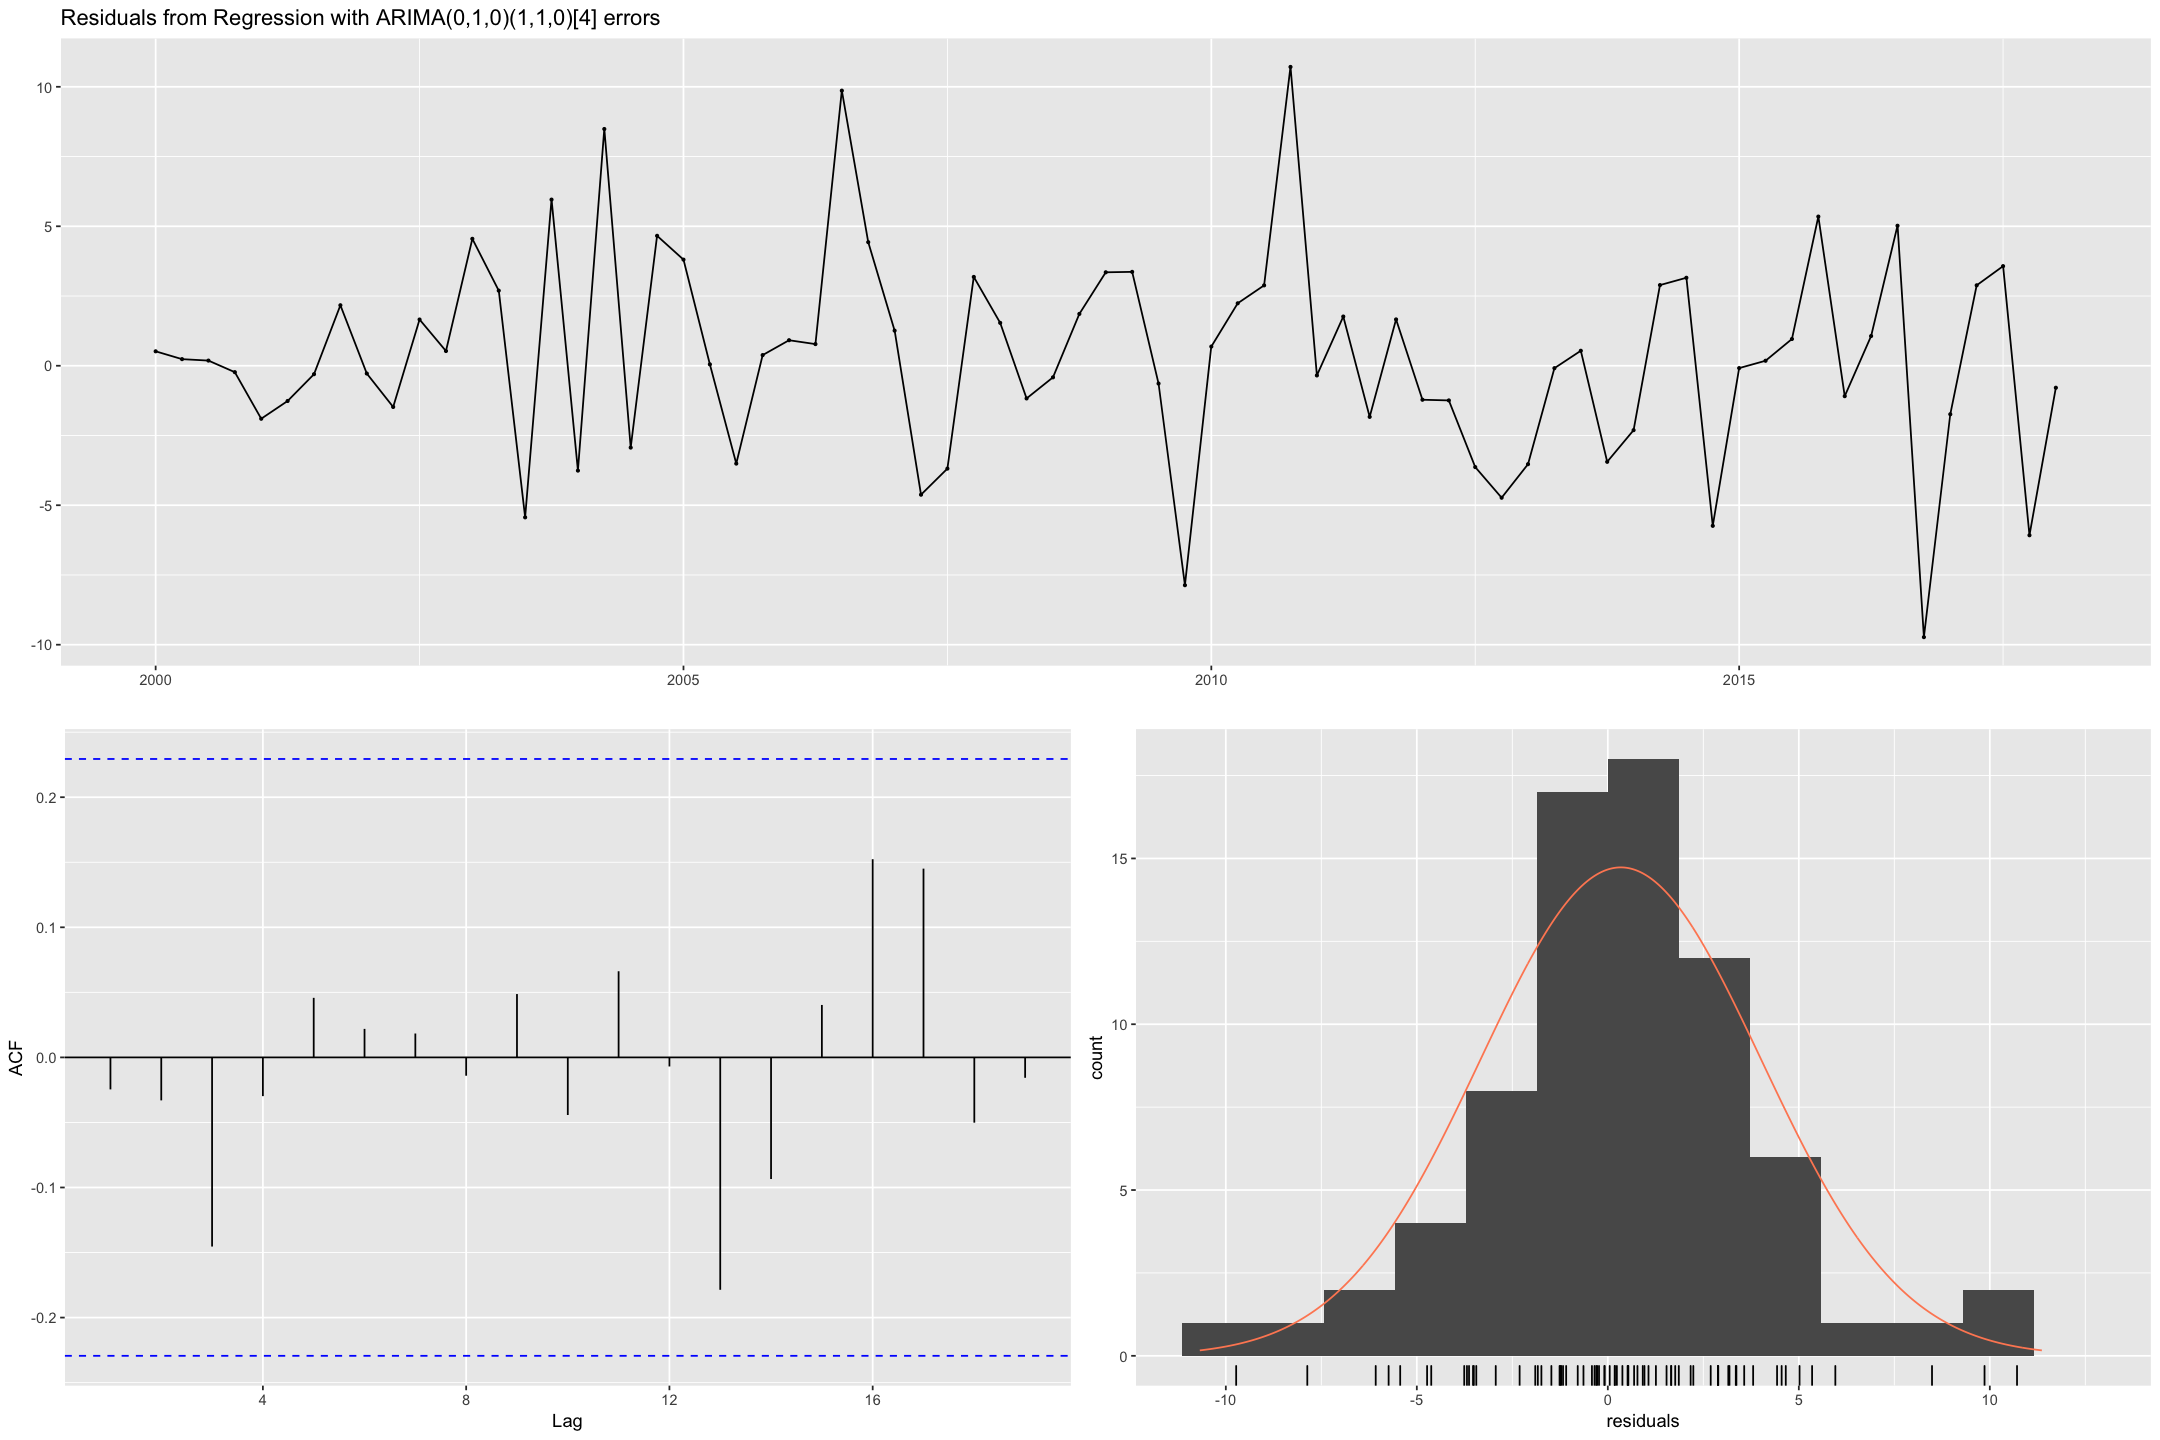

In [164]:
checkresiduals(forecast_complex1)


	Ljung-Box test

data:  Residuals from Regression with ARIMA(0,0,0)(0,1,0)[4] errors
Q* = 146.36, df = 6, p-value < 2.2e-16

Model df: 2.   Total lags used: 8



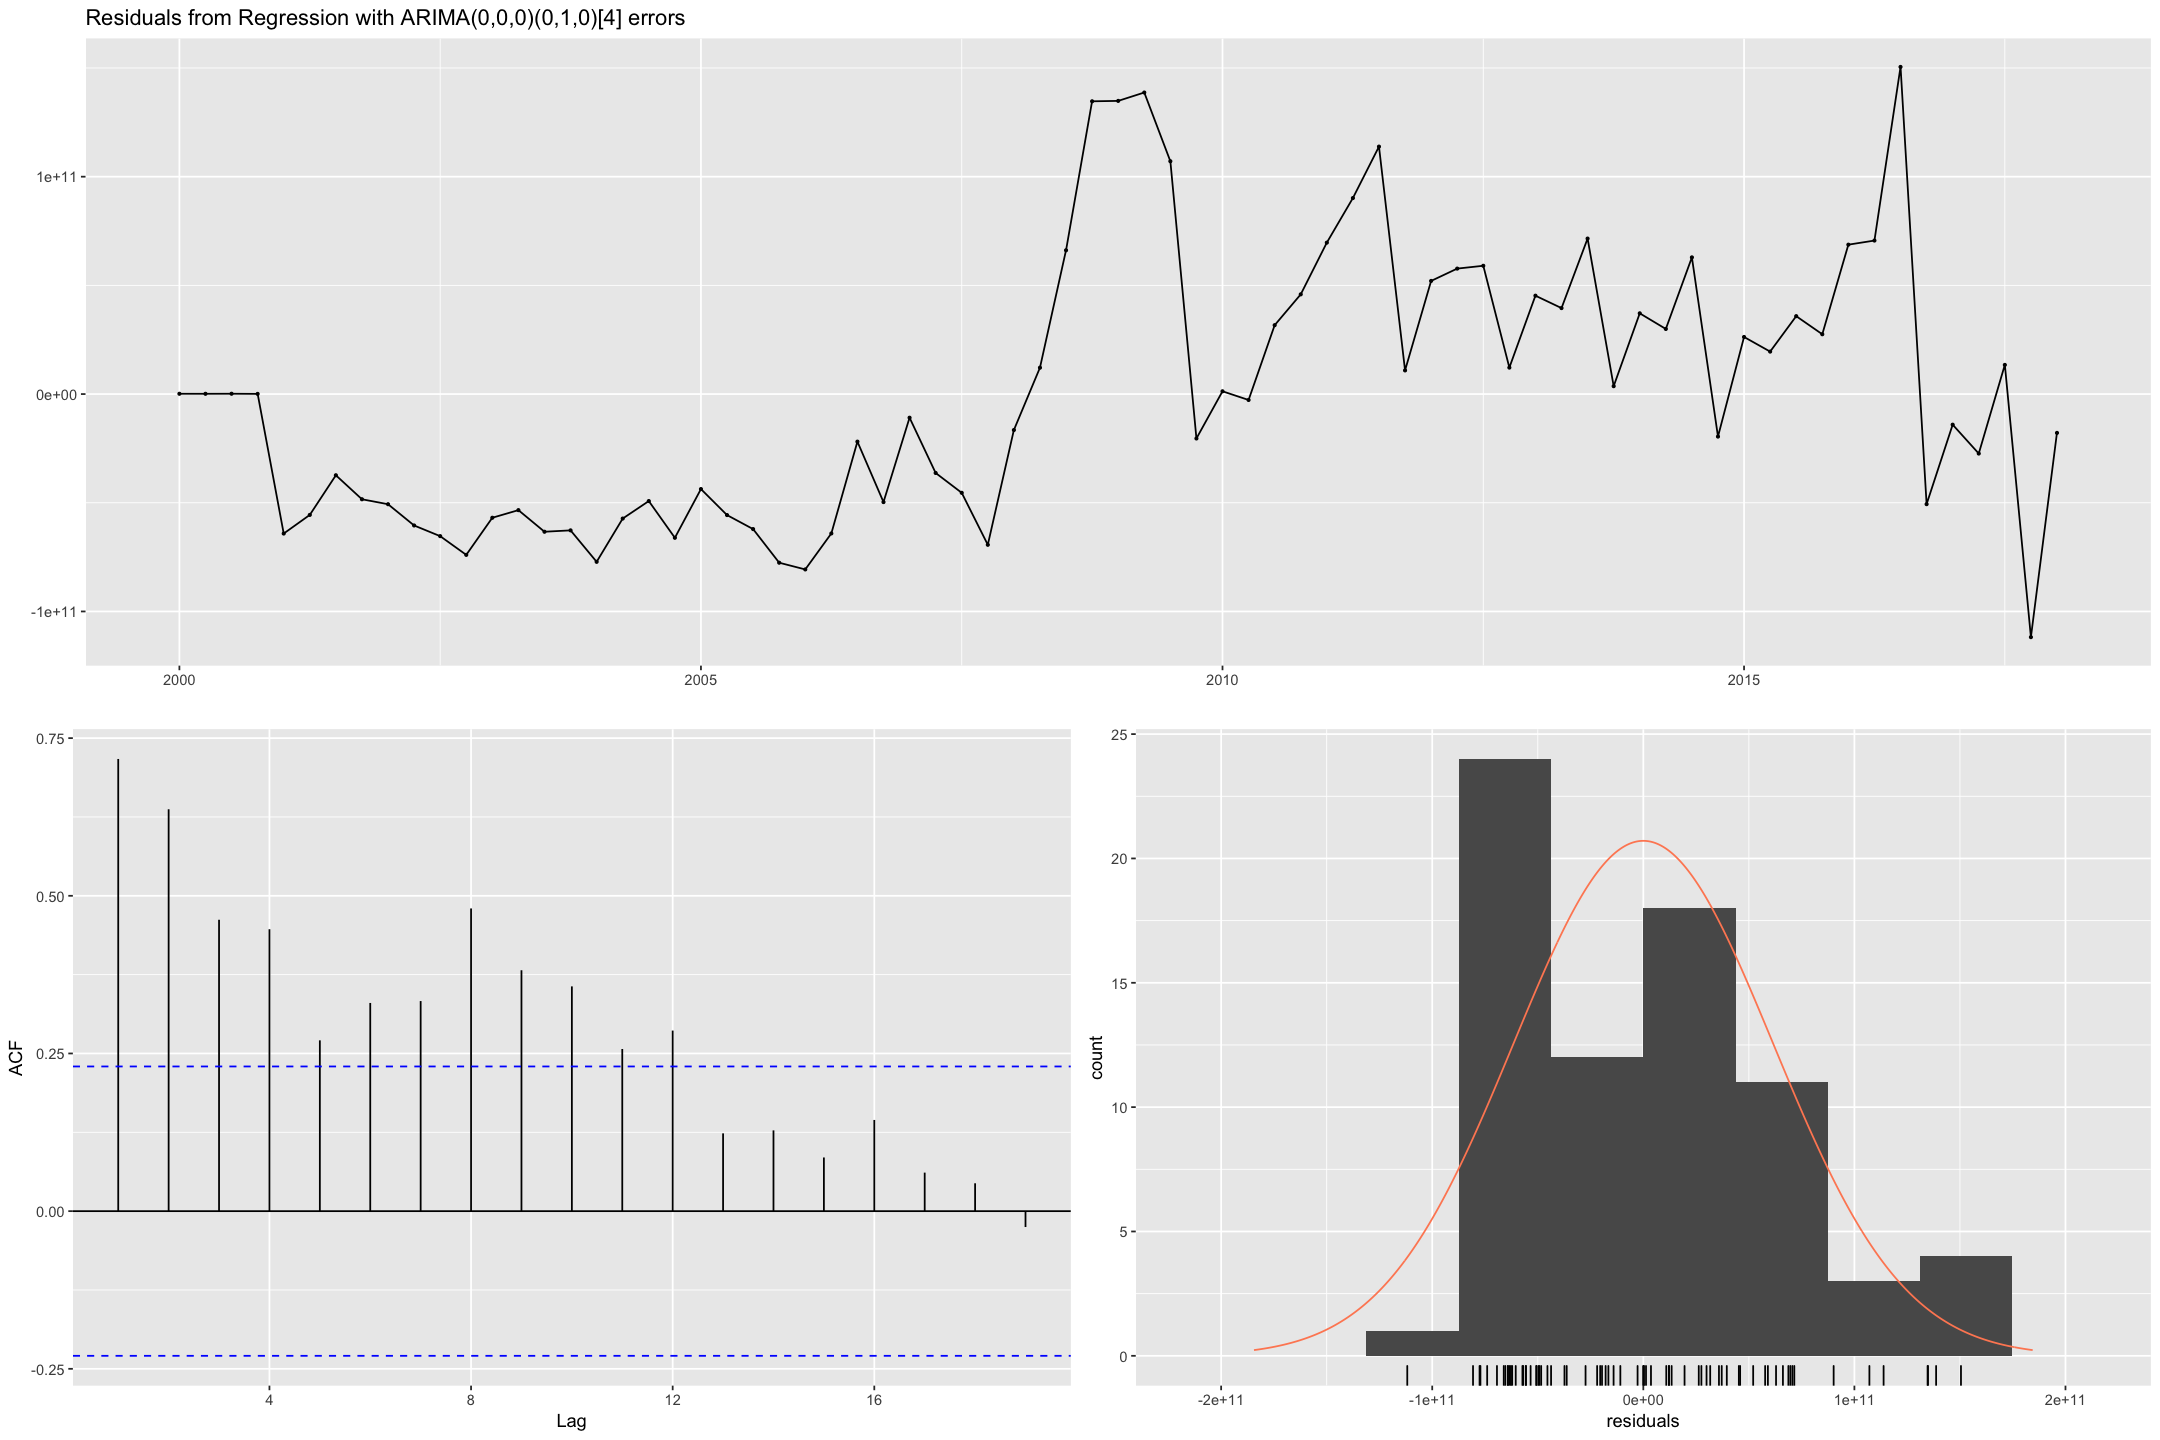

In [206]:
checkresiduals(forecast_1)

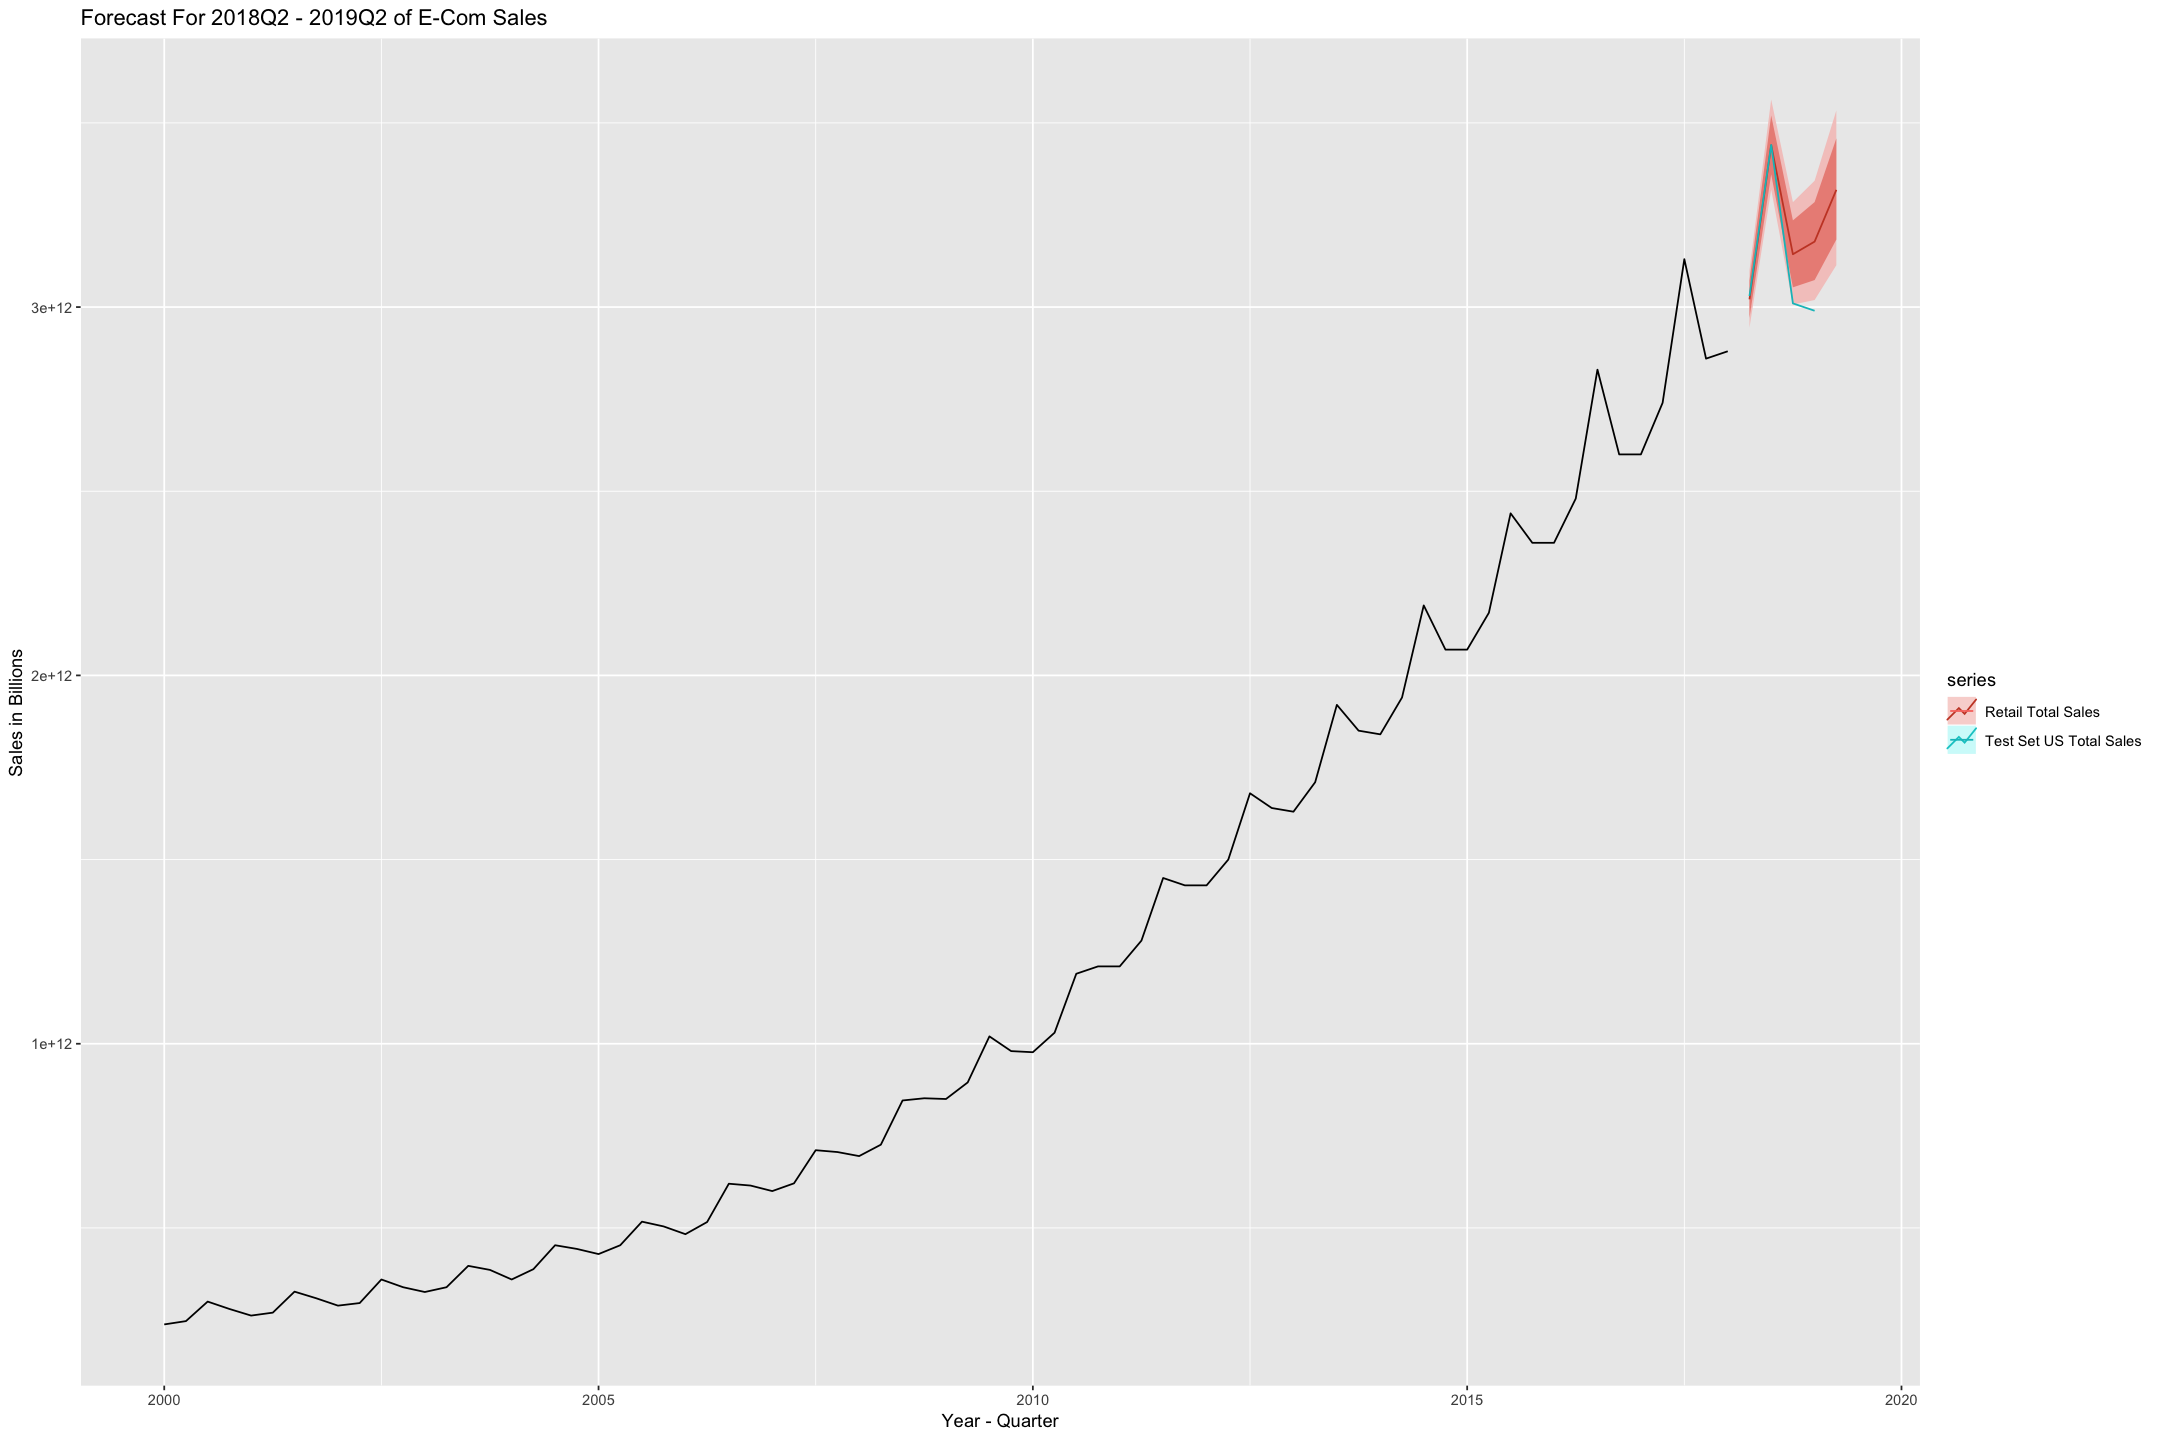

In [221]:
autoplot(trainUS,main = 'Forecast For 2018Q2 - 2019Q2 of E-Com Sales',xlab = 'Year - Quarter',ylab = 'Sales in Billions')+
  autolayer(forecast_complex1, "Retail Total Sales")+
  autolayer(testUS,series = 'Test Set US Total Sales')

In [211]:
fit_complex2<- auto.arima(trainUS,xreg=trainREG_AMZN,D=1,approximation = F,allowdrift = T,allowmean = T,lambda = BoxCox.lambda(trainUS))
forecast_complex2<-forecast(fit_complex2,xreg = testREG_AMZN);forecast_complex2
acc_AMZN_more<-accuracy(f = forecast_complex2,x = testUS);acc_AMZN_more

Warning message in auto.arima(trainUS, xreg = trainREG_AMZN, D = 1, approximation = F, :
“Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.”


        Point Forecast        Lo 80        Hi 80        Lo 95        Hi 95
2018 Q2   3.029192e+12 2.975120e+12 3.084049e+12 2.946811e+12 3.113410e+12
2018 Q3   3.445044e+12 3.359082e+12 3.532761e+12 3.314279e+12 3.579915e+12
2018 Q4   3.164255e+12 3.064549e+12 3.266547e+12 3.012798e+12 3.321761e+12
2019 Q1   3.172257e+12 3.055258e+12 3.292823e+12 2.994740e+12 3.358119e+12
2019 Q2   3.341795e+12 3.187324e+12 3.502215e+12 3.107903e+12 3.589603e+12

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-2714746175,24087097881,13726891509,-0.1059298,1.179387,0.08982034,-0.2427534,NA
Test set,-85186890900,119413496195,85590917990,-2.8350628,2.848397,0.56005437,0.2877794,0.4088516


In [208]:
summary(fit_complex2)

Series: trainUS 
Regression with ARIMA(0,2,1)(1,1,0)[4] errors 
Box Cox transformation: lambda= 0.1977409 

Coefficients:
          ma1     sar1    xreg
      -0.9674  -0.4843  -1e-04
s.e.   0.0532   0.1026   5e-04

sigma^2 estimated as 16.98:  log likelihood=-194.49
AIC=396.99   AICc=397.63   BIC=405.81

Training set error measures:
                      ME        RMSE         MAE        MPE     MAPE       MASE
Training set -2714746175 24087097881 13726891509 -0.1059298 1.179387 0.08982034
                   ACF1
Training set -0.2427534


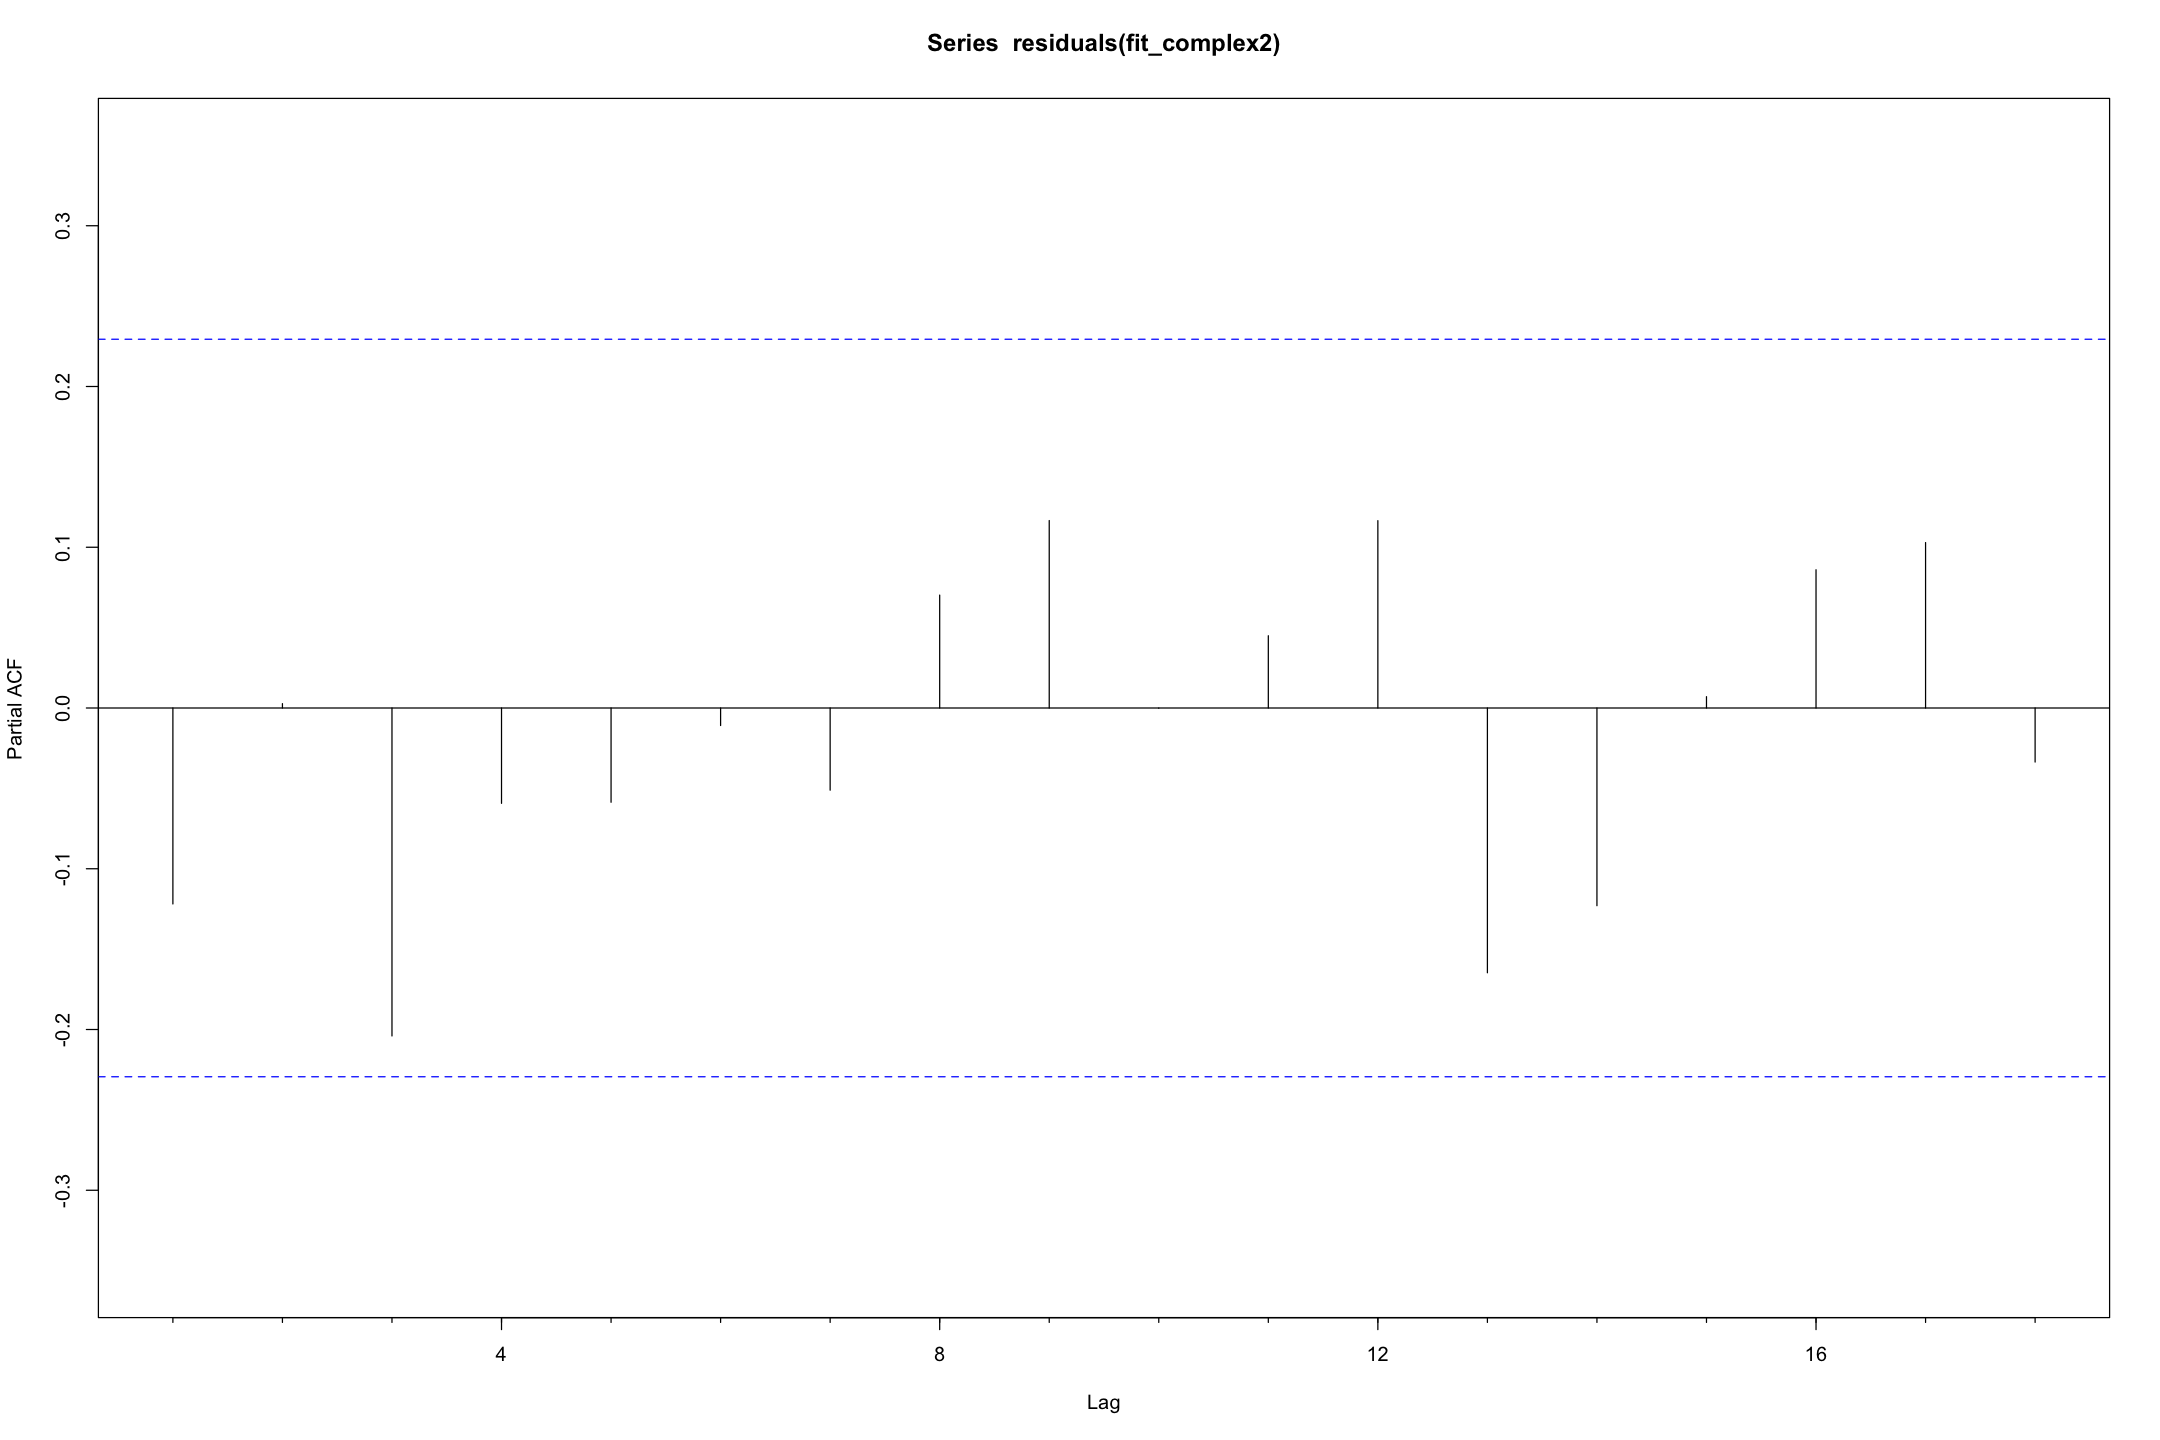

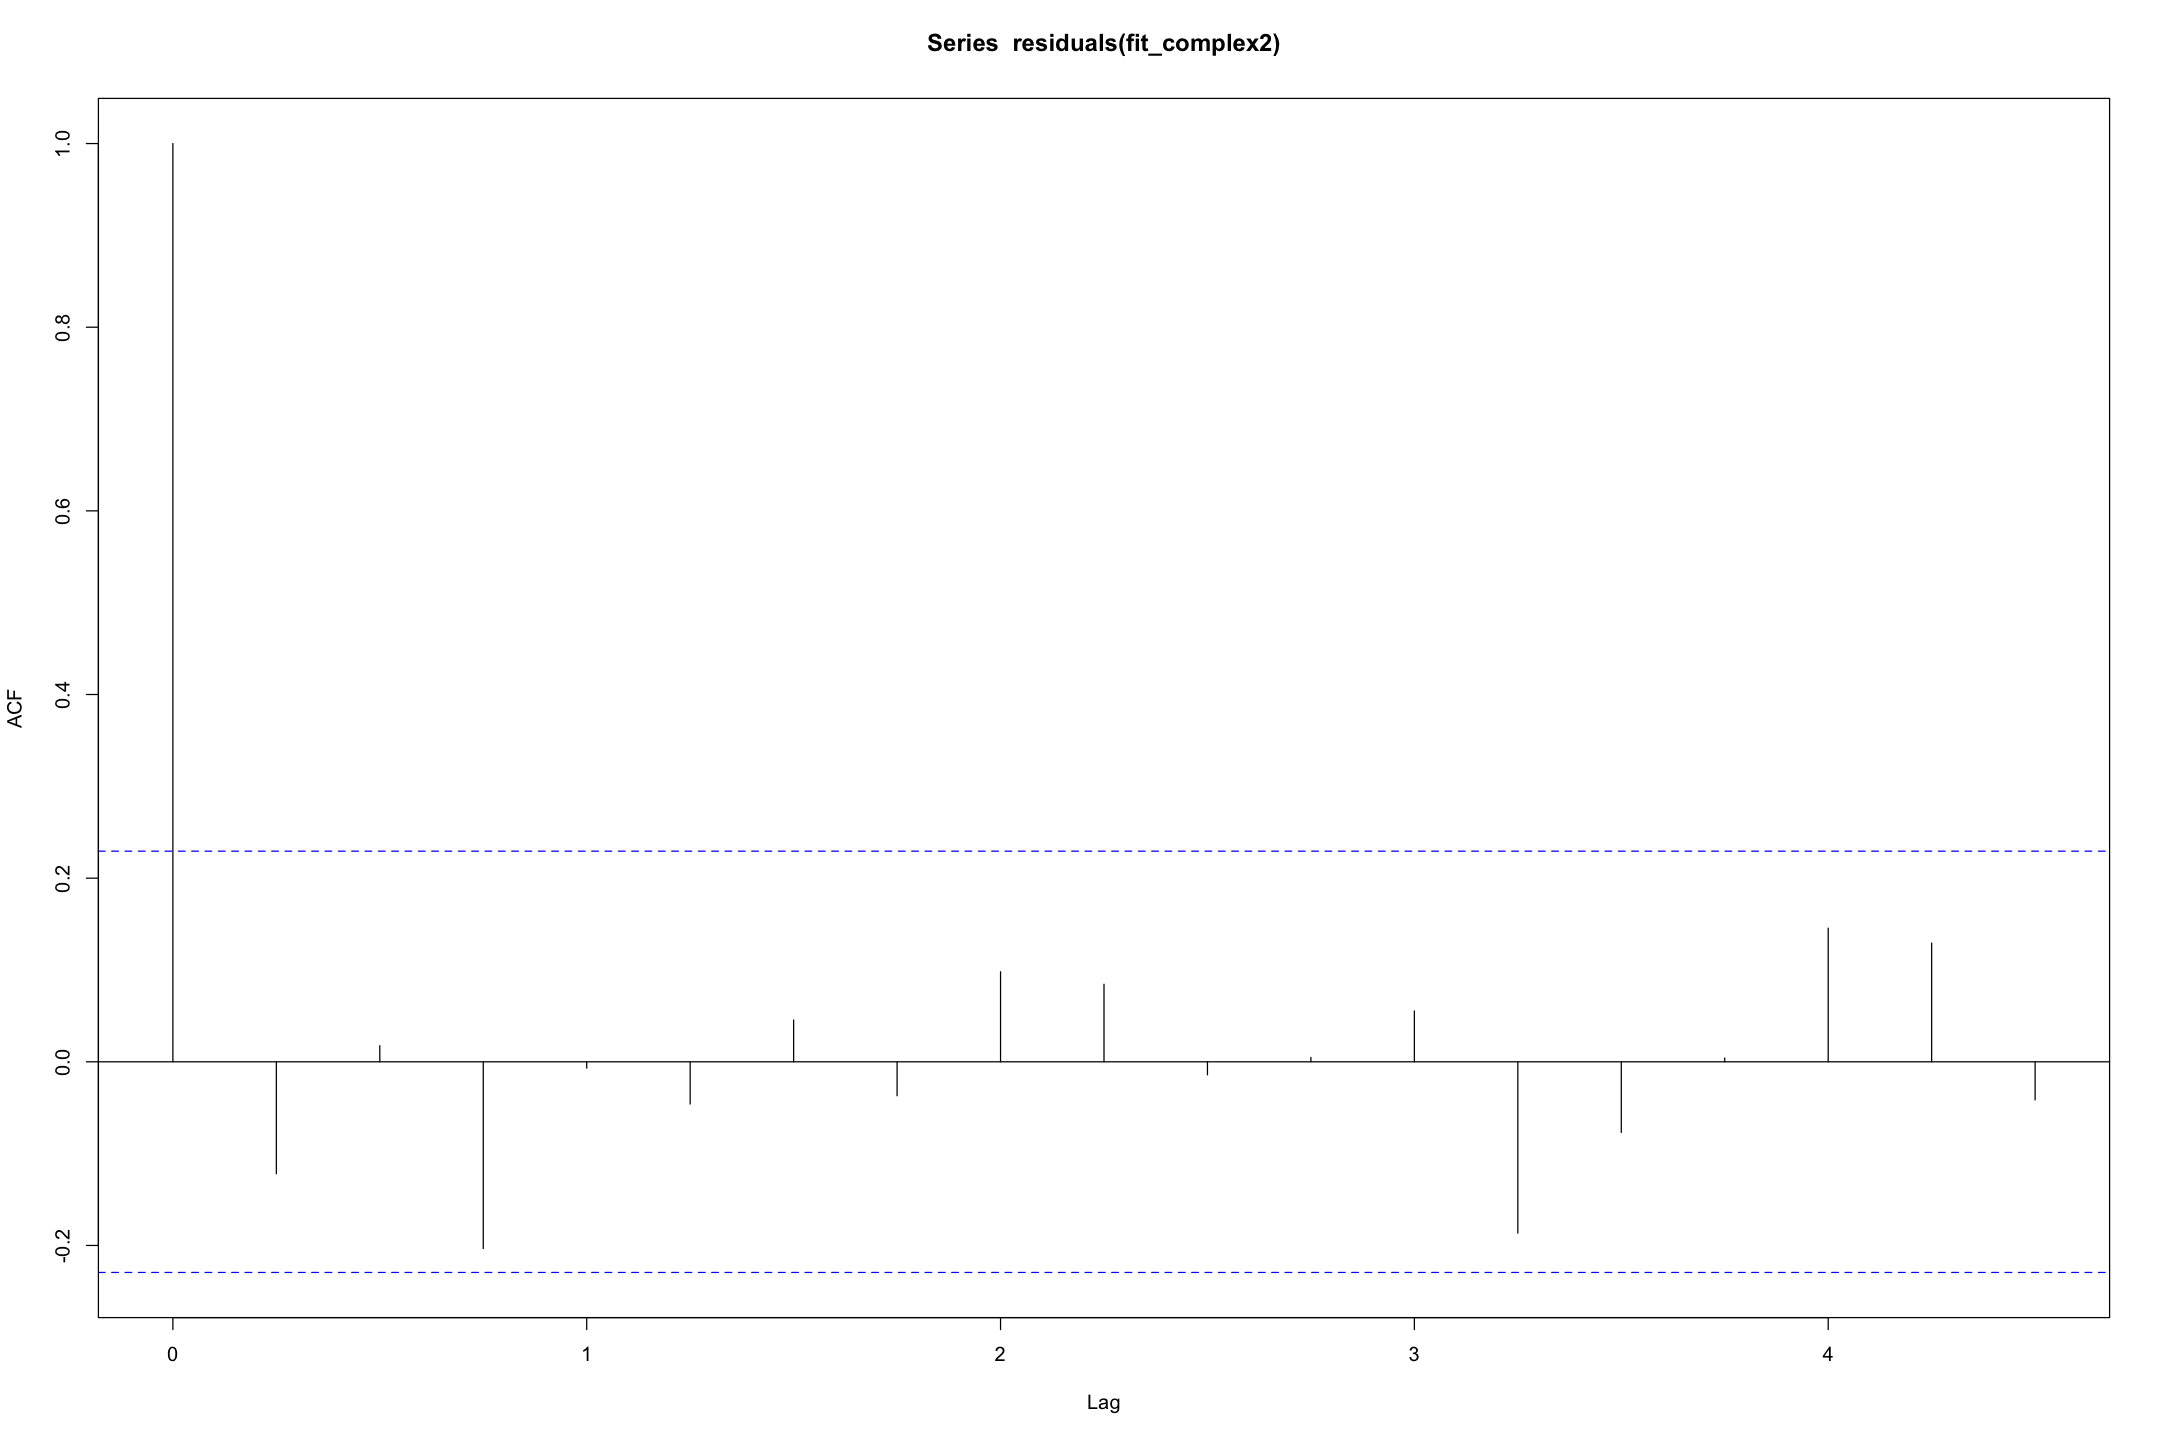

In [209]:
pacf = Pacf(residuals(fit_complex2))
acf = acf(residuals(fit_complex2))

In [214]:
fit_complex3<- auto.arima(trainUS,xreg=trainREG_FEDEX,start.p=1,D=1,approximation = F,allowdrift = F,allowmean = T,lambda = BoxCox.lambda(trainUS))
forecast_complex3<-forecast(fit_complex3,xreg = testREG_FEDEX);forecast_complex3
acc_FEDEX_more1<-accuracy(f = forecast_complex3,x = testUS);acc_FEDEX_more1

        Point Forecast        Lo 80        Hi 80        Lo 95        Hi 95
2018 Q2   3.038378e+12 2.952028e+12 3.126742e+12 2.907120e+12 3.174347e+12
2018 Q3   3.429735e+12 3.297137e+12 3.566577e+12 3.228628e+12 3.640770e+12
2018 Q4   3.120823e+12 2.997932e+12 3.247724e+12 2.934467e+12 3.316557e+12
2019 Q1   3.161324e+12 3.037150e+12 3.289539e+12 2.973018e+12 3.359081e+12
2019 Q2   3.337137e+12 3.118733e+12 3.567645e+12 3.007850e+12 3.694738e+12

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,4907512666,32887338332,22256148558,0.7203688,2.105668,0.1456306,-0.1517835,NA
Test set,-70065039088,102236732127,75197605120,-2.3474583,2.496661,0.4920469,0.2619587,0.3552844


In [215]:
summary(fit_complex3)

Series: trainUS 
Regression with ARIMA(0,0,1)(1,1,0)[4] errors 
Box Cox transformation: lambda= 0.1977409 

Coefficients:
         ma1    sar1    xreg
      0.9787  0.9283  0.0976
s.e.  0.0632  0.0373  1.1805

sigma^2 estimated as 43.49:  log likelihood=-230.12
AIC=468.24   AICc=468.87   BIC=477.18

Training set error measures:
                     ME        RMSE         MAE       MPE     MAPE      MASE
Training set 4907512666 32887338332 22256148558 0.7203688 2.105668 0.1456306
                   ACF1
Training set -0.1517835


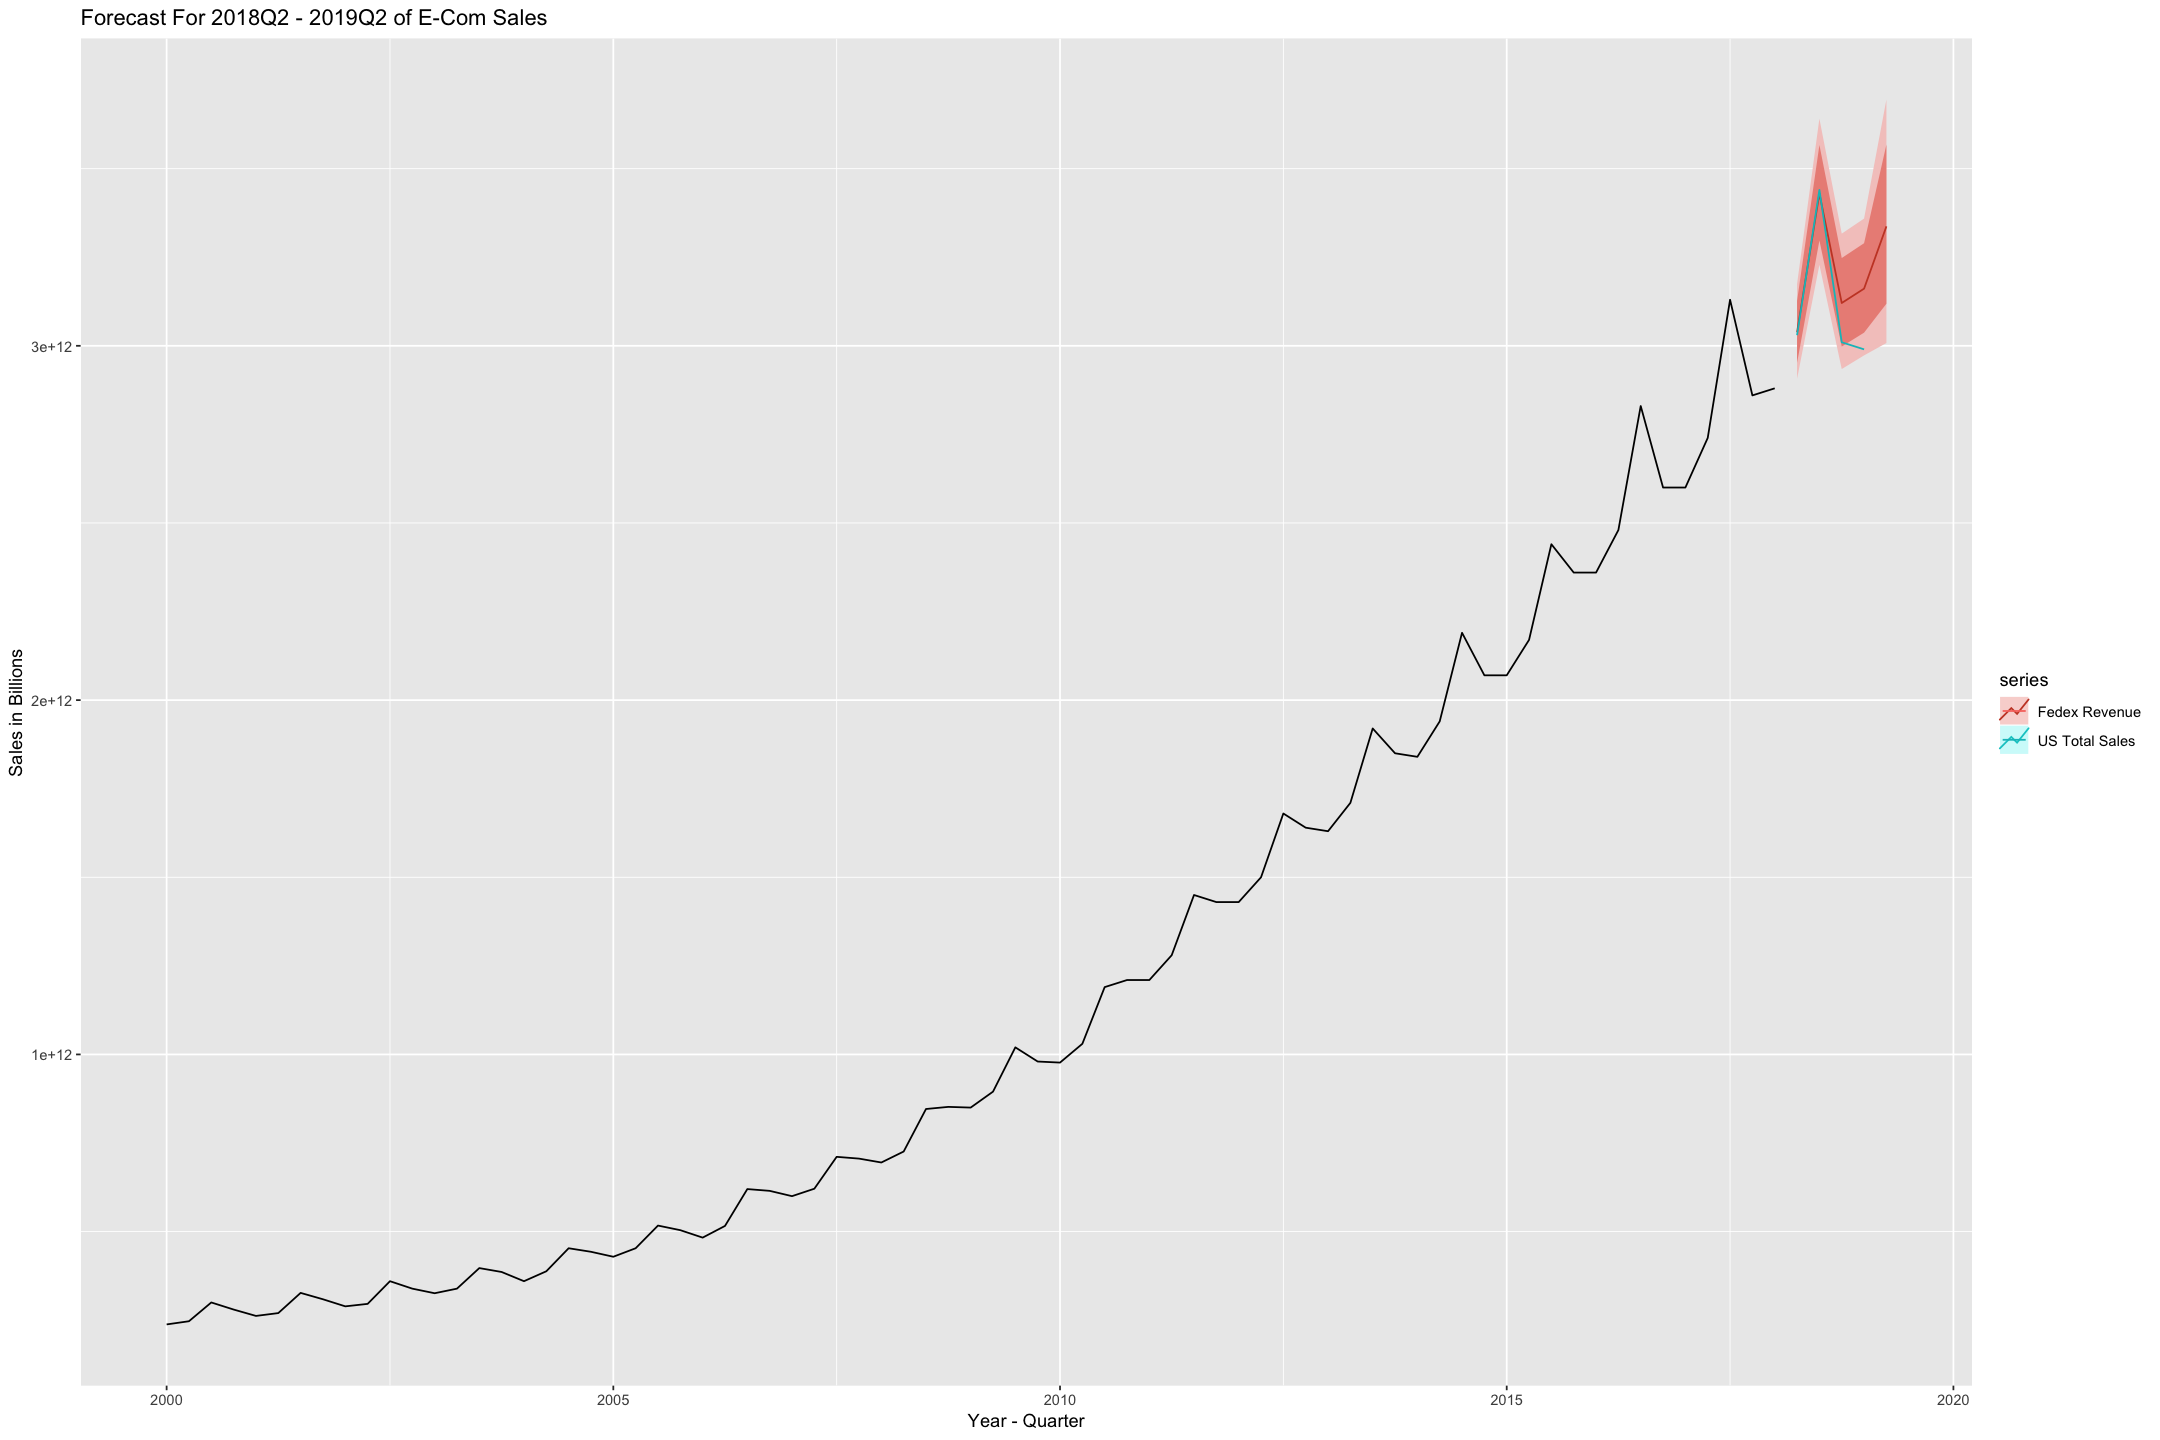

In [219]:
autoplot(trainUS,main = 'Forecast For 2018Q2 - 2019Q2 of E-Com Sales',xlab = 'Year - Quarter',ylab = 'Sales in Billions')+
  autolayer(forecast_complex3,series = 'Fedex Revenue')+
  autolayer(testUS,series = 'US Total Sales')

In [75]:
#Final Comparison

v_forecasts <- c(forecast_1,forecast_2,forecast_3,forecast_4,forecast_5,forecast_more)

,Qtr1,Qtr2,Qtr3,Qtr4
2014,,,,2.07e+12
2015,2.07e+12,2.17e+12,2.44e+12,2.36e+12
2016,2.36e+12,2.48e+12,2.83e+12,2.60e+12
2017,2.60e+12,2.74e+12,3.13e+12,2.86e+12
2018,2.88e+12,,,


In [116]:
acc<-accuracy(forecast_more,x = testUS)
acc

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-1059022487,21256652170,15034279301,-0.04486618,0.5414593,0.05476714,-0.1253416,NA
Test set,-73207692567,113678291890,85626392876,-2.46188840,2.8349260,0.31192137,0.2717217,0.3914316


In [117]:
acc[,"MAPE"]

Training set     Test set 
   0.5414593    2.8349260